![image](https://docs.google.com/uc?export=download&id=1NUy1Q-abpoV9XYK9qT9t8Mdhj3ZVlveO)


# **Taller 1**

La Clínica de Innovación y Atención, quiere iniciar un departamento de investigación del cerebro con enfoque de proporcionar diagnósticos más precisos y rápidos. Para eso quiere apoyarse en el uso de IA para analizar casos de tumores cerebrales utilizando un conjunto de datos que contiene imágenes de cerebros con presencia de tumor y otras de cerebros en estado normal. Inicialmente, la clínica desea implementar un modelo de clasificación que pueda predecir a partir de una imagen escaneada del cerebro de un paciente si puede tener o no un tumor.

Como prueba de concepto, la empresa ha proporcionado el conjunto de imágenes del cerebro con y sin tumor. Se espera que usted implemente el mejor modelo posible siguiendo las indicaciones proporcionadas:

1.	***Entrenamiento de un perceptrón multicapa***.

*   Confirme si su modelo generaliza bien, o si presenta sobreajuste o subajuste. Si es alguna de las dos últimas opciones, ¿qué opciones propone para que la red MLP generalice mejor?

2.	***Entrenamiento de un undercompleted autoencoder***
*   Realice una reducción de la dimensionalidad. Sobre el nuevo conjunto de características, construya el modelo de clasificación con un perceptrón multicapa:

3.  Resuma en una tabla la comparación de resultados entre el modelo obtenido en el punto 1 (MLP) y el undercompleted autoencoder. ¿Cuál de los dos modelos le ofrecería al negocio y por qué?


Datos: https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset


# Librerías

En primera instancia, se configura el entorno de trabajo para tareas relacionadas con el aprendizaje automático y el procesamiento de imágenes utilizando TensorFlow, scikit-learn y otras librerías útiles para llevar a cabo la manipulación de los datos de entrada y la construcción de los modelos requeridos.

In [ ]:
!pip install scikeras

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import random

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer
from sklearn.pipeline import Pipeline, FeatureUnion

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras.utils import plot_model

from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier, KerasRegressor

import os
from PIL import Image
import shutil

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.13.0


# Lectura y entendimiento del negocio

El código a continuación ejecuta una serie de acciones enfocadas en la descarga y preparación de una colección de datos de Kaggle, facilitando la obtención de las imágenes que se utilizarán en el entrenamiento de los modelos. En primer lugar, se configura la autenticación copiando el archivo de credenciales 'kaggle.json' en el directorio adecuado, estableciendo permisos de lectura y escritura. Posteriormente, se verifica la conexión a Kaggle y se procede a descargar el conjunto de datos de interés ([Brain Tumor Dataset](https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset)). Luego, se descomprime el archivo y se imprime el número de elementos que se hallan en los dos directorios existentes.

In [ ]:
!ls -lha kaggle.json
!pip install -q kaggle # Instalar el paquete Kaggle
!mkdir -p ~/.kaggle # Crear el directorio .kaggle
!cp kaggle.json ~/.kaggle/ # Mover la llave al directorio creado
!pwd # Verificar el directorio de trabajo actual

# Dar permisos de lectura y escritura
!chmod 600 ~/.kaggle/kaggle.json

#4 Verificación de sanidad para acceder a Kaggle
!kaggle datasets list

-rw-r--r-- 1 root root 67 Sep 17 17:56 kaggle.json
/content
ref                                                        title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/top-spotify-songs-2023                    Most Streamed Spotify Songs 2023                    47KB  2023-08-26 11:04:57           9607        311  1.0              
josephinelsy/spotify-top-hit-playlist-2010-2022            Spotify Top Hit Playlist (2010-2022)               210KB  2023-09-08 06:11:44           1745         51  1.0              
rahulmenon1758/car-resale-prices                           Car resale data - 2023                             487KB  2023-09-12 09:28:47            528         25  1.0              
harshalhonde/starbucks-reviews

In [ ]:
# Descargar los conjuntos de datos
!kaggle datasets download -d preetviradiya/brian-tumor-dataset

!unzip -qq /content/brian-tumor-dataset.zip

# Listar contenidos
%cd "/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor"
%ls | wc -l

%cd "/content/Brain Tumor Data Set/Brain Tumor Data Set/Healthy"
%ls | wc -l

100% 107M/107M [00:06<00:00, 20.0MB/s]
100% 107M/107M [00:06<00:00, 18.2MB/s]
/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor
2513
/content/Brain Tumor Data Set/Brain Tumor Data Set/Healthy
2087


Obtenida la información vinculada a las tomografías computarizadas y su clasificación en *Brain Tumor* (tumor cerebral) y *Healthy* (saludable), se generan estadísticas acerca del tamaño de las imágenes y la distribución de clases, lo cual resulta útil para comprender la composición y características del espacio de entrada. Primeramente, se define la ubicación del directorio raíz del conjunto de datos. Después, se declara una función que examina el tamaño de las imágenes en cada una de las dos categorías. Para cada categoría, se recorren todos los elementos en el directorio correspondiente y se identifican las dimensiones mínimas y máximas de las TACs. En paralelo, se realiza el conteo y se informa acerca del número total de imágenes y la proporción de cada clase.

In [ ]:
root_dir = '/content/Brain Tumor Data Set/Brain Tumor Data Set'

def identify_image_sizes(directory):
    files_number_brain_tumor = 0
    files_number_healthy = 0

    for label in ['Brain Tumor', 'Healthy']:
        label_path = os.path.join(directory, label)

        min_width, min_height = float('inf'), float('inf')
        max_width, max_height = 0, 0

        # Recorrer las imágenes existentes en el directorio
        for img_file in os.listdir(label_path):
            img_path = os.path.join(label_path, img_file)

            if label == "Brain Tumor":
              files_number_brain_tumor += 1
            else:
              files_number_healthy += 1

            # Examinar el archivo únicamente si es una imagen
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                with Image.open(img_path) as img:
                    width, height = img.size

                    # Actualizar las dimensiones mínimas y máximas
                    min_width = min(min_width, width)
                    min_height = min(min_height, height)
                    max_width = max(max_width, width)
                    max_height = max(max_height, height)

        print(f"\nClase: {label}")
        print(f"Tamaño mínimo: {min_width}x{min_height} píxeles")
        print(f"Tamaño máximo: {max_width}x{max_height} píxeles")
    return files_number_brain_tumor, files_number_healthy

files_number_brain_tumor, files_number_healthy = identify_image_sizes(root_dir)
total = files_number_brain_tumor + files_number_healthy
print(f"\nNúmero de imágenes: {total}")
print(f"Número de imágenes clase «Brain Tumor»: {files_number_brain_tumor} ({(files_number_brain_tumor/total * 100):.2f}%)")
print(f"Número de imágenes clase «Healthy»: {files_number_healthy} ({(files_number_healthy/total * 100):.2f}%)")


Brain Tumor

Clase: Brain Tumor
Tamaño mínimo: 175x167 píxeles
Tamaño máximo: 1275x1427 píxeles
Healthy

Clase: Healthy
Tamaño mínimo: 150x168 píxeles
Tamaño máximo: 1920x1446 píxeles

Número de imágenes: 4600
Número de imágenes clase «Brain Tumor»: 2513 (54.63%)
Número de imágenes clase «Healthy»: 2087 (45.37%)


El conjunto de datos consta de un total de 4600 imágenes que representan las dos clases a predecir: *Brain Tumor* y *Healthy*. Las dos categorías se encuentran adecuadamente representadas en la colección de imágenes, con una proporción del 54.63% para tumores cerebrales y del 45.37% para cerebros sanos. Además, se observa una variabilidad en las dimensiones de las imágenes, tanto en términos de ancho como de alto, lo que se traduce en una diversidad en la cantidad de píxeles que abarcan.

# Preparación de los datos

Se inicializan las variables que definen el tamaño de lote y las dimensiones de las imágenes que se utilizarán en el entrenamiento y prueba del modelo, unificando así el ancho y alto de cada una. A continuación, se configuran los parámetros y las rutas a los directorios asociados a los cerebros con tumor y los cerebros sanos. Posteriormente, se crea un DataFrame que etiqueta las imágenes de acuerdo con su contenido y este se divide en un conjunto de entrenamiento y otro prueba. Por último, se organizan y copian los archivos en una carpeta destinada a cada clase.

In [ ]:
batch_size = 32
img_height = 128
img_width = 128

tumor_dir = '/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor'
healthy_dir = '/content/Brain Tumor Data Set/Brain Tumor Data Set/Healthy'

list_tumor = os.listdir(tumor_dir)
list_healthy = os.listdir(healthy_dir)

list_tumor.extend(list_healthy)

df = pd.DataFrame(list_tumor, columns = ["File Name"])
df['Label'] = df["File Name"].apply(lambda x: "HEALTHY" if "not" in x.lower() else "CANCER")
df

File Name    Label
0          Cancer (1439).jpg   CANCER
1          Cancer (1724).jpg   CANCER
2          Cancer (2094).jpg   CANCER
3            Cancer (69).tif   CANCER
4          Cancer (2073).jpg   CANCER
...                      ...      ...
4595   Not Cancer  (487).jpg  HEALTHY
4596  Not Cancer  (1383).jpg  HEALTHY
4597   Not Cancer  (602).jpg  HEALTHY
4598   Not Cancer  (902).jpg  HEALTHY
4599   Not Cancer  (768).jpg  HEALTHY

[4600 rows x 2 columns]

In [ ]:
train, test = train_test_split(df, test_size=0.2, stratify=df['Label'] , random_state=42)
train.head()

File Name   Label
484   Cancer (2108).jpg  CANCER
1739   Cancer (307).jpg  CANCER
1834  Cancer (1234).jpg  CANCER
1351  Cancer (1172).jpg  CANCER
868   Cancer (1152).jpg  CANCER

In [ ]:
train_healthy_dir = '/content/Brain Tumor Data Set/Brain Tumor Data Set/train/Healthy/'
test_healthy_dir = '/content/Brain Tumor Data Set/Brain Tumor Data Set/test/Healthy/'
train_tumor_dir = '/content/Brain Tumor Data Set/Brain Tumor Data Set/train/Brain Tumor/'
test_tumor_dir = '/content/Brain Tumor Data Set/Brain Tumor Data Set/test/Brain Tumor/'

os.makedirs(os.path.dirname(train_healthy_dir), exist_ok=True)
os.makedirs(os.path.dirname(train_tumor_dir), exist_ok=True)

for i in train["File Name"]:
  if "not" in i.lower():
    shutil.copy(os.path.join(healthy_dir, i), train_healthy_dir)
  else:
    shutil.copy(os.path.join(tumor_dir, i), train_tumor_dir)

os.makedirs(os.path.dirname(test_healthy_dir), exist_ok=True)
os.makedirs(os.path.dirname(test_tumor_dir), exist_ok=True)

for i in test["File Name"]:
  if "not" in i.lower():
    shutil.copy(os.path.join(healthy_dir, i), os.path.join(test_healthy_dir,i))
  else:
    shutil.copy(os.path.join(tumor_dir, i), os.path.join(test_tumor_dir,i))

Se definen las rutas a los directorios asociados a la fase de entrenamiento (train_data_dir) y a la de prueba (test_data_dir). De tal forma, se emplea la función image_dataset_from_directory de TensorFlow para cargar los datos desde dichas carpetas. Al invocar la función se establecen varios parámetros como lo son el tamaño de imagen, la extensión del lote, el modo de color (en escala de grises) y una semilla para la aleatorización de datos.

In [ ]:
train_data_dir = '/content/Brain Tumor Data Set/Brain Tumor Data Set/train/'
test_data_dir = '/content/Brain Tumor Data Set/Brain Tumor Data Set/test/'

# Cargar el conjunto de datos de entrenamiento
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    # Es una radiografía, entonces en tonos de grises
    color_mode="grayscale")

# Cargar el conjunto de datos de prueba
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    # Es una radiografía, entonces en tonos de grises
    color_mode="grayscale")

Found 3610 files belonging to 2 classes.
Found 904 files belonging to 2 classes.


Se obtienen las clases (etiquetas) de los datos de entrenamiento y se imprimen. Luego, empleando únicamente tales datos, se filtran las imágenes de las clases *BRAIN TUMOR* y *HEALTHY* y se almacenan en dos listas. Por último, se visualizan 5 TACs de cada categoría utilizando Matplotlib, distinguiendo entre las imágenes de tumores cerebrales y las de cerebros saludables. Esto proporciona una vista preliminar de la colección de fotografías de interés antes de continuar con la construcción y entrenamiento del modelo.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['Brain Tumor', 'Healthy']


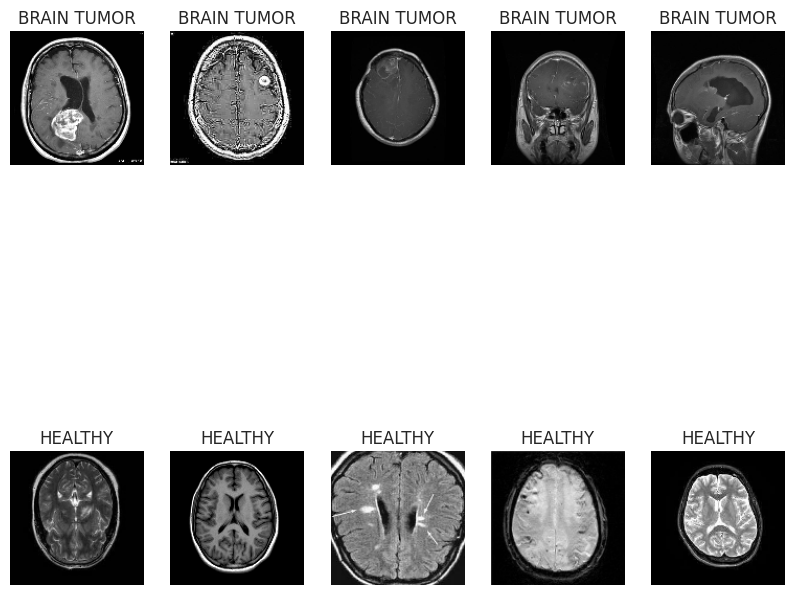

In [ ]:
# Filtra las imágenes de las clases "BRAIN TUMOR" y "HEALTHY" del conjunto de datos
tumor_images = []
healthy_images = []

for images, labels in train_ds:
    for i in range(len(images)):
        if labels[i].numpy() == 0:  # La etiqueta 0 corresponde a la clase "BRAIN TUMOR"
            tumor_images.append(images[i].numpy())
        elif labels[i].numpy() == 1:  # La etiqueta 1 corresponde a la clase "HEALTHY"
            healthy_images.append(images[i].numpy())

plt.figure(figsize=(10, 10))

for i in range(5):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(tumor_images[i].reshape((img_height, img_width)).astype("uint8"), cmap='gray')
    plt.title("BRAIN TUMOR")
    plt.axis("off")

for i in range(5):
    ax = plt.subplot(2, 5, i + 6)
    plt.imshow(healthy_images[i].reshape((img_height, img_width)).astype("uint8"), cmap='gray')
    plt.title("HEALTHY")
    plt.axis("off")

plt.show()

Es necesario convertir las colecciones de imágenes de entrenamiento y prueba en arreglos *numpy* que puedan ser incorporados como entrada para un modelo de aprendizaje de máquina. Adicionalmente, las imágenes se normalizan dividiendo todos los valores de píxeles por 255, a fin de escalarlos en el rango [0, 1]. Asimismo, la totalidad de matrices se aplanan en vectores unidimensionales y se imprimen las formas resultantes. Este preprocesamiento es indispensable para adaptar los datos a un formato adecuado para el posterior entrenamiento, dado que las redes neuronales comúnmente trabajan con arreglos numéricos como entrada.

In [ ]:
def convert_array(X, Y, ds):
  for images, labels in ds:
      X.append(images.numpy())
      Y.append(labels.numpy())

  X = np.concatenate(X, axis=0)
  Y = np.concatenate(Y, axis=0)

  return X, Y

X_train , Y_train, X_test, Y_test = [], [], [], []
X_train, Y_train = convert_array(X_train, Y_train, train_ds)
X_test, Y_test = convert_array(X_test, Y_test, test_ds)

In [ ]:
X_train = X_train / 255
X_test = X_test / 255

In [ ]:
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
print(X_train.shape)
print(X_test.shape)

(3610, 16384)
(904, 16384)


# Modelo 1: Entrenamiento de perceptrón multicapa

## Entrenamiento

Una vez que los datos se han preparado en el formato adecuado para su procesamiento, el siguiente paso implica la definición de un modelo inicial para una tarea de clasificación, específicamente, un perceptrón multicapa. Inicialmente, se crea una función que puede generar diferentes configuraciones de redes neuronales según los hiperparámetros proporcionados como argumentos. Es importante destacar que esta función genera una capa de salida con 2 neuronas y utiliza la activación *softmax* de acuerdo con el número de categorías en el conjunto de datos. En lo que respecta al modelo base, se especifica el uso de 6 capas ocultas con activación *relu*. En concreto, se plantean tres capas densas con 512, 512 y 256 neuronas, respectivamente, junto con tres capas de *dropout* intercaladas con probabilidades de 0.2, 0.1 y 0.25, respectivamente. Asimismo, se establecen los hiperparámetros de entrenamiento, como el optimizador, la cantidad de épocas y el tamaño del lote, para así guiar el proceso de aprendizaje de la red neuronal.

In [ ]:
def get_classifier_1(meta, n_layers, activation, hidden_layer_1, dropout_1,
                            hidden_layer_2 = None, dropout_2 = None,
                            hidden_layer_3 = None, dropout_3 = None):
    n_features_in_ = meta["n_features_in_"]
    hidden_neurons = [hidden_layer_1, hidden_layer_2, hidden_layer_3]
    dropouts = [dropout_1, dropout_2, dropout_3]
    classifier_model = Sequential(name="Perceptron_Multicapa_1")

    # Capa de entrada
    classifier_model.add(Input(shape=(n_features_in_,)))

    for i in range(n_layers):
        classifier_model.add(Dense(hidden_neurons[i], activation=activation))
        classifier_model.add(Dropout(dropouts[i]))

    # Se cuenta con dos clases (según la presencia o ausencia de tumor)
    classifier_model.add(Dense(2, activation='softmax'))
    classifier_model.summary()
    return classifier_model

In [ ]:
model_callbacks = [
  tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=7, verbose=1, mode='max', baseline=None, restore_best_weights=False),
  #tf.keras.callbacks.TensorBoard(log_dir='/content/logs')
  #tf.keras.callbacks.ModelCheckpoint(filepath='/content/models/classifier_1.{epoch:02d}-{loss:.2f}.h5'),
]

In [ ]:
classifier_model_1 = KerasClassifier(
    get_classifier_1,
    loss = "sparse_categorical_crossentropy",
    callbacks = model_callbacks,
    batch_size = batch_size,
    epochs = 50,
    optimizer = 'adam',
    n_layers = 3,
    hidden_layer_1 = 512,
    dropout_1 = 0.2,
    hidden_layer_2 = 512,
    dropout_2 = 0.1,
    hidden_layer_3 = 256,
    dropout_3 = 0.25,
    metrics = ["accuracy"],
    activation = "relu",
)

In [ ]:
pipeline_classifier_1 = Pipeline([('classifier_1', classifier_model_1)])
classifier_1_log = pipeline_classifier_1.fit(X_train, Y_train, classifier_1__validation_data = (X_test, Y_test))

Model: "Perceptron_Multicapa_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               8389120   
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 2)      

## Validación

Compeltado el entrenamiento, es factible evaluar el rendimiento del modelo empleando el conjunto de datos asociado a esta etapa. A nivel global, la red neuronal base revela un desempeño satisfactorio. Por un lado, para la etiqueta 0 (*BRAIN TUMOR*), las métricas de precisión, recall y f1-score son del 87%, 98% y 92%, respectivamente. En cuanto a la etiqueta 1 (*HEALTHY*), se logra una precisión del 97%, un recall del 83% y un f1-score del 90%. Adicionalmente, el promedio ponderado de las dos categorías es superior al 90% para cualquiera de las métricas. No obstante, es importante destacar que esta predicción se realizó sobre la colección de imágenes utilizada para entrenar el modelo, lo que introduce un sesgo a razón de que la red ya está familiarizada con tales datos. En virtud de lo anterior, se examinan los resultados sobre la partición *X_test*, obteniendo una media similar para las tres métricas mencionadas, el cual oscila entre 88% y 90%.

In [ ]:
y_pred = np.argmax(pipeline_classifier_1['classifier_1'].model_.predict(X_train), axis=1)
print(classification_report(y_true=Y_train, y_pred=y_pred))

113/113 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1940
           1       0.97      0.83      0.90      1670

    accuracy                           0.91      3610
   macro avg       0.92      0.91      0.91      3610
weighted avg       0.92      0.91      0.91      3610



In [ ]:
y_pred_test = np.argmax(pipeline_classifier_1['classifier_1'].model_.predict(X_test), axis=1)
print(classification_report(y_true=Y_test, y_pred=y_pred_test))

29/29 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       487
           1       0.96      0.78      0.86       417

    accuracy                           0.88       904
   macro avg       0.90      0.88      0.88       904
weighted avg       0.90      0.88      0.88       904



Con el propósito de ilustrar el comportamiento del aprendizaje del perceptrón multicapa, se consulta el historial de entrenamiento disponible en el objeto *classifier_1_log["classifier_1"].history_*. Tal variable contiene datos relativos a la pérdida y la precisión sobre el conjunto de entrenamiento y el de validación (en este caso, correspondiente a la partición de prueba) a lo largo de las épocas. De tal forma, el gráfico proporciona información visual acerca de cómo el modelo aprende a medida que avanza en el proceso y si experimenta condiciones de sobreajuste o de subajuste.

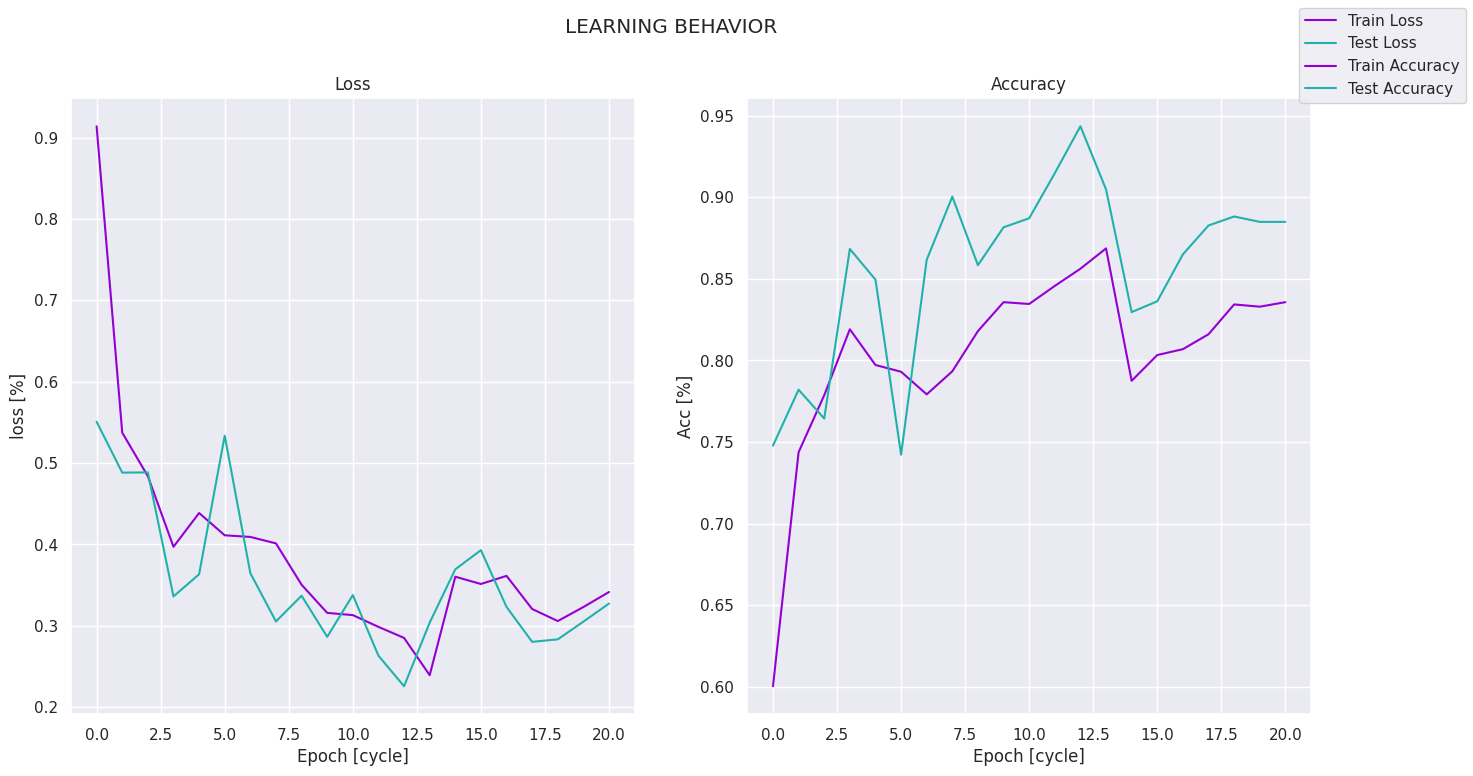

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,8))

history_classifier = classifier_1_log["classifier_1"].history_
ax1.plot(history_classifier["loss"], 'darkviolet', label = "Train Loss")
ax1.plot(history_classifier["val_loss"], 'lightseagreen', label = "Test Loss")
ax2.plot(history_classifier["accuracy"], 'darkviolet', label = "Train Accuracy")
ax2.plot(history_classifier["val_accuracy"], 'lightseagreen', label = "Test Accuracy")

fig.suptitle("LEARNING BEHAVIOR")
ax1.grid(True)
ax2.grid(True)
ax1.set_title("Loss")
ax2.set_title("Accuracy")
ax1.set(xlabel = "Epoch [cycle]", ylabel = "loss [%]")
ax2.set(xlabel = "Epoch [cycle]", ylabel = "Acc [%]")
fig.legend()
fig.show()

En referencia a la pérdida (loss), se observa que tanto los datos de entrenamiento como los datos de validación exhiben tendencias similares. Sin embargo, en la gráfica de la exactitud se puede evidenciar un pequeño subajuste de los datos. Lo anterior se deduce al notar que la red MLP adquiere porcentajes mayores en esta métrica al trabajar con los datos de validación que con los de entrenamiento durante la mayor parte del proceso. Con el objetivo de abordar este problema, la solución que se propone consiste en realizar la búsqueda de hiperparámetros por medio de una validación cruzada.

## Búsqueda de hiperparámetros

A fin de identificar el modelo más apropiado para obtener predicciones precisas en datos no vistos, se ejecuta la búsqueda de los valores óptimos de los hiperparámetros del clasificador, acompañada por la técnica de validación cruzada. Primero, se delimitan las magnitudes sobre las que se iterará para cada hiperparámetro objetivo, así como la métrica que se desea mejorar entre modelos, en esta ocasión el _accuracy_. Además, se indica que la validación cruzada constará de cinco particiones y que las divisiones serán las mismas entre llamados. Seguidamente, se procede con el entrenamiento de los modelos.

In [ ]:
param_search = {
    "classifier_1__n_layers": [1, 2, 3],
    "classifier_1__hidden_layer_1": [512, 256, 128],
    "classifier_1__hidden_layer_2": [512, 256, 128],
    "classifier_1__hidden_layer_3": [512, 256, 128],
    "classifier_1__dropout_1": [0.1, 0.2, 0.5],
    "classifier_1__dropout_2": [0.1, 0.2, 0.5],
    "classifier_1__dropout_3": [0.1, 0.2, 0.5],
    "classifier_1__activation": ["relu", "sigmoid"],
    "classifier_1__optimizer": ["adam", "sgd"],
    "classifier_1__optimizer__learning_rate": [0.0001, 0.001, 0.1],
    "classifier_1__epochs": [100],
}

search_classifier_1 = RandomizedSearchCV(pipeline_classifier_1, param_search, cv=5, scoring='accuracy', verbose=2, n_iter=10, random_state=42)

In [ ]:
search_classifier_1.fit(X_train, Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Model: "Perceptron_Multicapa_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_312 (Dense)           (None, 128)               2097280   
                                                                 
 dropout_199 (Dropout)       (None, 128)               0         
                                                                 
 dense_313 (Dense)           (None, 2)                 258       
                                                                 
Total params: 2097538 (8.00 MB)
Trainable params: 2097538 (8.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
91/91 [==============================] - 1s 3ms/step - loss: 1.6942 - accuracy: 0.5003
Epoch 2/100
91/91 [==============================] - 0s 3ms/step - loss: 0.8815 - accuracy: 0.4955
Epoch 3/100

Model: "Perceptron_Multicapa_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_318 (Dense)           (None, 128)               2097280   
                                                                 
 dropout_202 (Dropout)       (None, 128)               0         
                                                                 
 dense_319 (Dense)           (None, 2)                 258       
                                                                 
Total params: 2097538 (8.00 MB)
Trainable params: 2097538 (8.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
91/91 [==============================] - 1s 3ms/step - loss: 1.2764 - accuracy: 0.5114
Epoch 2/100
91/91 [==============================] - 0s 3ms/step - loss: 0.9699 - accuracy: 0.5090
Epoch 3/100
91/91 [==============================] - 0s 3ms/step - loss:

Model: "Perceptron_Multicapa_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_328 (Dense)           (None, 256)               4194560   
                                                                 
 dropout_208 (Dropout)       (None, 256)               0         
                                                                 
 dense_329 (Dense)           (None, 256)               65792     
                                                                 
 dropout_209 (Dropout)       (None, 256)               0         
                                                                 
 dense_330 (Dense)           (None, 2)                 514       
                                                                 
Total params: 4260866 (16.25 MB)
Trainable params: 4260866 (16.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoc

Model: "Perceptron_Multicapa_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_341 (Dense)           (None, 128)               2097280   
                                                                 
 dropout_217 (Dropout)       (None, 128)               0         
                                                                 
 dense_342 (Dense)           (None, 512)               66048     
                                                                 
 dropout_218 (Dropout)       (None, 512)               0         
                                                                 
 dense_343 (Dense)           (None, 128)               65664     
                                                                 
 dropout_219 (Dropout)       (None, 128)               0         
                                                                 
 dense_344 (Dense)           (None, 2)      

Model: "Perceptron_Multicapa_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_357 (Dense)           (None, 512)               8389120   
                                                                 
 dropout_229 (Dropout)       (None, 512)               0         
                                                                 
 dense_358 (Dense)           (None, 512)               262656    
                                                                 
 dropout_230 (Dropout)       (None, 512)               0         
                                                                 
 dense_359 (Dense)           (None, 2)                 1026      
                                                                 
Total params: 8652802 (33.01 MB)
Trainable params: 8652802 (33.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoc

Model: "Perceptron_Multicapa_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_369 (Dense)           (None, 512)               8389120   
                                                                 
 dropout_237 (Dropout)       (None, 512)               0         
                                                                 
 dense_370 (Dense)           (None, 512)               262656    
                                                                 
 dropout_238 (Dropout)       (None, 512)               0         
                                                                 
 dense_371 (Dense)           (None, 2)                 1026      
                                                                 
Total params: 8652802 (33.01 MB)
Trainable params: 8652802 (33.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoc

Model: "Perceptron_Multicapa_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_381 (Dense)           (None, 256)               4194560   
                                                                 
 dropout_245 (Dropout)       (None, 256)               0         
                                                                 
 dense_382 (Dense)           (None, 512)               131584    
                                                                 
 dropout_246 (Dropout)       (None, 512)               0         
                                                                 
 dense_383 (Dense)           (None, 2)                 1026      
                                                                 
Total params: 4327170 (16.51 MB)
Trainable params: 4327170 (16.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoc

91/91 [==============================] - 2s 4ms/step - loss: 0.7307 - accuracy: 0.5229
Epoch 2/100
91/91 [==============================] - 0s 4ms/step - loss: 0.6606 - accuracy: 0.5980
Epoch 3/100
91/91 [==============================] - 0s 4ms/step - loss: 0.6282 - accuracy: 0.6406
Epoch 4/100
91/91 [==============================] - 0s 4ms/step - loss: 0.5947 - accuracy: 0.6728
Epoch 5/100
91/91 [==============================] - 0s 4ms/step - loss: 0.5633 - accuracy: 0.6998
Epoch 6/100
91/91 [==============================] - 0s 4ms/step - loss: 0.5276 - accuracy: 0.7542
Epoch 7/100
91/91 [==============================] - 0s 4ms/step - loss: 0.5164 - accuracy: 0.7621
Epoch 8/100
91/91 [==============================] - 0s 4ms/step - loss: 0.4790 - accuracy: 0.7780
Epoch 9/100
91/91 [==============================] - 0s 4ms/step - loss: 0.4362 - accuracy: 0.8102
Epoch 10/100
91/91 [==============================] - 0s 4ms/step - loss: 0.4063 - accuracy: 0.8258
Epoch 11/100
91/91 [=

Model: "Perceptron_Multicapa_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_407 (Dense)           (None, 512)               8389120   
                                                                 
 dropout_264 (Dropout)       (None, 512)               0         
                                                                 
 dense_408 (Dense)           (None, 256)               131328    
                                                                 
 dropout_265 (Dropout)       (None, 256)               0         
                                                                 
 dense_409 (Dense)           (None, 128)               32896     
                                                                 
 dropout_266 (Dropout)       (None, 128)               0         
                                                                 
 dense_410 (Dense)           (None, 2)      

Model: "Perceptron_Multicapa_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_423 (Dense)           (None, 512)               8389120   
                                                                 
 dropout_276 (Dropout)       (None, 512)               0         
                                                                 
 dense_424 (Dense)           (None, 256)               131328    
                                                                 
 dropout_277 (Dropout)       (None, 256)               0         
                                                                 
 dense_425 (Dense)           (None, 128)               32896     
                                                                 
 dropout_278 (Dropout)       (None, 128)               0         
                                                                 
 dense_426 (Dense)           (None, 2)      

Model: "Perceptron_Multicapa_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_439 (Dense)           (None, 256)               4194560   
                                                                 
 dropout_288 (Dropout)       (None, 256)               0         
                                                                 
 dense_440 (Dense)           (None, 256)               65792     
                                                                 
 dropout_289 (Dropout)       (None, 256)               0         
                                                                 
 dense_441 (Dense)           (None, 256)               65792     
                                                                 
 dropout_290 (Dropout)       (None, 256)               0         
                                                                 
 dense_442 (Dense)           (None, 2)      

91/91 [==============================] - 2s 3ms/step - loss: 0.9554 - accuracy: 0.6305
Epoch 2/100
91/91 [==============================] - 0s 3ms/step - loss: 0.5177 - accuracy: 0.7472
Epoch 3/100
91/91 [==============================] - 0s 3ms/step - loss: 0.4324 - accuracy: 0.8213
Epoch 4/100
91/91 [==============================] - 0s 3ms/step - loss: 0.3964 - accuracy: 0.8355
Epoch 5/100
91/91 [==============================] - 0s 3ms/step - loss: 0.3481 - accuracy: 0.8584
Epoch 6/100
91/91 [==============================] - 0s 3ms/step - loss: 0.2905 - accuracy: 0.8878
Epoch 7/100
91/91 [==============================] - 0s 3ms/step - loss: 0.2679 - accuracy: 0.8975
Epoch 8/100
91/91 [==============================] - 0s 3ms/step - loss: 0.2329 - accuracy: 0.9131
Epoch 9/100
91/91 [==============================] - 0s 3ms/step - loss: 0.2159 - accuracy: 0.9204
Epoch 10/100
91/91 [==============================] - 0s 3ms/step - loss: 0.1883 - accuracy: 0.9304
Epoch 11/100
91/91 [=

91/91 [==============================] - 2s 10ms/step - loss: 1.0200 - accuracy: 0.4969
Epoch 2/100
91/91 [==============================] - 0s 3ms/step - loss: 0.8427 - accuracy: 0.5017
Epoch 3/100
91/91 [==============================] - 0s 3ms/step - loss: 0.9584 - accuracy: 0.5007
Epoch 4/100
91/91 [==============================] - 0s 3ms/step - loss: 0.8199 - accuracy: 0.4986
Epoch 5/100
91/91 [==============================] - 0s 3ms/step - loss: 0.7890 - accuracy: 0.5111
Epoch 6/100
91/91 [==============================] - 0s 3ms/step - loss: 0.7439 - accuracy: 0.5100
Epoch 7/100
91/91 [==============================] - 0s 3ms/step - loss: 0.8354 - accuracy: 0.5052
Epoch 8/100
91/91 [==============================] - 0s 3ms/step - loss: 0.8245 - accuracy: 0.4986
Epoch 9/100
91/91 [==============================] - 0s 3ms/step - loss: 1.0170 - accuracy: 0.4952
Epoch 10/100
91/91 [==============================] - 0s 3ms/step - loss: 0.8210 - accuracy: 0.5076
Epoch 11/100
91/91 [

91/91 [==============================] - 1s 10ms/step - loss: 0.8260 - accuracy: 0.4861
Epoch 9/100
91/91 [==============================] - 0s 3ms/step - loss: 0.7761 - accuracy: 0.4979
Epoch 10/100
91/91 [==============================] - 0s 3ms/step - loss: 0.8358 - accuracy: 0.5114
Epoch 11/100
91/91 [==============================] - 0s 3ms/step - loss: 0.8355 - accuracy: 0.5187
Epoch 12/100
91/91 [==============================] - 0s 3ms/step - loss: 0.9110 - accuracy: 0.5055
Epoch 13/100
91/91 [==============================] - 0s 3ms/step - loss: 0.7610 - accuracy: 0.5235
Epoch 14/100
91/91 [==============================] - 0s 3ms/step - loss: 0.7579 - accuracy: 0.5139
Epoch 15/100
91/91 [==============================] - 0s 3ms/step - loss: 0.7757 - accuracy: 0.5090
Epoch 16/100
91/91 [==============================] - 0s 3ms/step - loss: 0.7849 - accuracy: 0.5211
Epoch 17/100
91/91 [==============================] - 0s 3ms/step - loss: 0.8866 - accuracy: 0.5055
Epoch 18/100


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('classifier_1',
                                              KerasClassifier(activation='relu', batch_size=32, callbacks=[<keras.src.callbacks.EarlyStopping object at 0x7c62441520b0>], dropout_1=0.2, dropout_2=0.1, dropout_3=0.25, epochs=50, hidden_layer_1=512, hidden_layer_2=512, hidden_layer_3=256, loss='sparse_categorical_crossentropy', metrics=['accurac...
                                        'classifier_1__dropout_3': [0.1, 0.2,
                                                                    0.5],
                                        'classifier_1__epochs': [100],
                                        'classifier_1__hidden_layer_1': [512,
                                                                         256,
                                                                         128],
                                        'classifier_1__hidden_layer_2': [512,
                                                                         256,
                                                                         128],
                                        'classifier_1__hidden_layer_3': [512,
                                                                         256,
                                                                         128],
                                        'classifier_1__n_layers': [1, 2, 3],
                                        'classifier_1__optimizer': ['adam',
                                                                    'sgd'],
                                        'classifier_1__optimizer__learning_rate': [0.0001,
                                                                                   0.001,
                                                                                   0.1]},
                   random_state=42, scoring='accuracy', verbose=2)

Confrontados los resultados para los distintos modelos, se evalua el desempeño del mejor de ellos sobre los datos de entrenamiento, donde se confirma una mejora significativa en la exactitud en comparación con el modelo base (99.70% frente al anterior 91%). Tal resultado era el esperado debido a la optimización de hiperparámetros que se llevó a cabo, la cual favorece la identificación de las propiedades que proveen un mejor desempeño.

In [ ]:
best_model_classifier_1 = search_classifier_1.best_estimator_['classifier_1'].model_
best_model_history = search_classifier_1.best_estimator_['classifier_1'].history_
best_model_classifier_1.save('/content/model/best_classifier_1.h5')
best_model_classifier_1 = tf.keras.models.load_model('/content/model/best_classifier_1.h5')
search_classifier_1.best_params_

{'classifier_1__optimizer__learning_rate': 0.1,
 'classifier_1__optimizer': 'sgd',
 'classifier_1__n_layers': 2,
 'classifier_1__hidden_layer_3': 256,
 'classifier_1__hidden_layer_2': 512,
 'classifier_1__hidden_layer_1': 256,
 'classifier_1__epochs': 100,
 'classifier_1__dropout_3': 0.5,
 'classifier_1__dropout_2': 0.5,
 'classifier_1__dropout_1': 0.2,
 'classifier_1__activation': 'sigmoid'}

In [ ]:
evaluation = best_model_classifier_1.evaluate(X_train, Y_train)

113/113 [==============================] - 0s 2ms/step - loss: 0.0263 - accuracy: 0.9970


Finalmente, se examina el comportamiento de la red neuronal sobre los datos de prueba. Se observa una ligera reducción en la métrica de interés (96.46% frenta al anterior 88%), lo cual se atribuye al hecho de que son imágenes desconocidas para la red neuronal. Simultáneamente, en virtud de la búsqueda de hiperparámetros realizada, se puede corroborar que ya no se presenta subajuste en el clasificador.

In [ ]:
evaluation = best_model_classifier_1.evaluate(X_test, Y_test)

29/29 [==============================] - 0s 3ms/step - loss: 0.1230 - accuracy: 0.9646


In [ ]:
y_pred_test = best_model_classifier_1.predict(X_test).argmax(axis=-1)
print('Reporte para el modelo sobre datos de prueba')
print('--------------------------------------------------------')
print(classification_report(y_true = Y_test,
                            y_pred = y_pred_test))

29/29 [==============================] - 0s 2ms/step
Reporte para el modelo sobre datos de prueba
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       487
           1       0.96      0.96      0.96       417

    accuracy                           0.96       904
   macro avg       0.96      0.96      0.96       904
weighted avg       0.96      0.96      0.96       904



La evaluación del comportamiento del clasificador se realiza mediante el análisis de la matriz de confusión. A pesar de que se observan falsos positivos y falsos negativos, estos representan un porcentaje insignificante, por lo que se puede afirmar con confianza que el modelo obtenido demuestra una destacada habilidad para discernir entre la presencia y ausencia de tumores cerebrales. Tal inferencia se fundamenta en la concentración de la mayoría de los datos en la diagonal principal de la cuadrícula.

Text(68.25, 0.5, 'Etiquetas predichas')

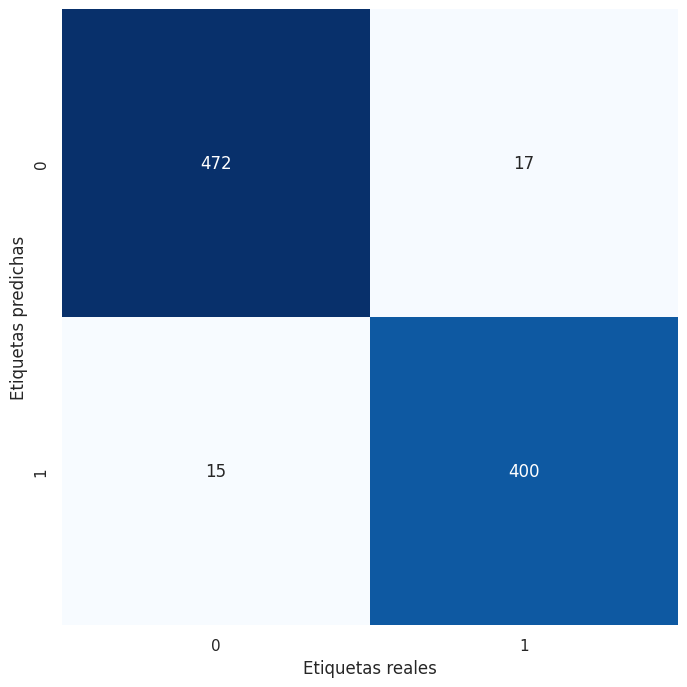

In [ ]:
plt.figure(figsize=(8,8))
mat = confusion_matrix(Y_test, y_pred_test)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False)
plt.xlabel('Etiquetas reales')
plt.ylabel('Etiquetas predichas')

# Modelo 2: Entrenamiento de un undercompleted autoencoder para realizar una reducción de la dimensionalidad y, sobre el nuevo conjunto de características, construir el modelo de clasificación con un perceptrón multicapa.


## Autoencoder

### Entrenamiento

Análoga a la implementación del primer modelo, se ha diseñado una función que facilita la creación de autoencoders. En particular, la función toma como argumentos los hiperparámetros de interés y construye el autocodificador considerando que la estructura del *encoder* debe ser inversa a la del *decoder*. Es importante destacar que en la capa de salida se emplea la función de activación sigmoide debido a la naturaleza de las imágenes y sus etiquetas.

Aprovechando la función descrita, se configura un *undercomplete autoencoder* compuesto por tres capas ocultas, tanto en el encoder como en el decoder, todas activadas con _relu_. El número de neuronas en estas capas es de 4096, 1024 y 512, respectivamente. Por su lado, en la capa que separa el codificador del decodificador y contiene la representación intermedia de baja dimensionalidad se disponen 256 neuronas. Cabe recalcar que el autoencoder se construyó como si estuviera resolviendo un problema de regresión, razón por la cual se aplicó la función de activación sigmoide en las neuronas de salida, junto con la función de pérdida (loss) *binary_crossentropy*.

En conjunto con el establecimiento de la arquitectura del autoencoder, se acotan los hiperparámetros de entrenamiento, los cuales incluyen el optimizador, el número de épocas y el tamaño del lote. Por último, se crea el *pipeline* vinculado al proceso y se entrena el modelo base.

In [ ]:
def get_autoencoder(meta, n_layers, activation, hidden_layer_1, hidden_layer_2 = None, hidden_layer_3 = None, encoder_layer = None):
    n_features_in_ = meta["n_features_in_"]
    hidden_neurons = [hidden_layer_1, hidden_layer_2, hidden_layer_3]
    autoencoder = Sequential(name="Autoencoder")

    # Capa de entrada
    autoencoder.add(Input(shape=(n_features_in_,)))

    # Creación del codificador
    for i in range(n_layers):
        autoencoder.add(Dense(hidden_neurons[i], activation=activation, name='Encoder_' + str(i + 1)))

    autoencoder.add(Dense(encoder_layer, activation=activation, name = "Encoder"))

    # Creación del decodificador
    for i in range(n_layers-1, -1, -1):
        autoencoder.add(Dense(hidden_neurons[i], activation=activation, name='Decoder_' + str(i + 1)))

    autoencoder.add(Dense(n_features_in_, activation='sigmoid'))
    autoencoder.summary()
    plot_model(autoencoder)
    return autoencoder

In [ ]:
autoencoder_callbacks = [
  tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7, verbose=1, mode='min', baseline=None, restore_best_weights=False),
  #tf.keras.callbacks.TensorBoard(log_dir='/content/logs')
  #tf.keras.callbacks.ModelCheckpoint(filepath='/content/models/classifier_1.{epoch:02d}-{loss:.2f}.h5'),
]

In [ ]:
autoencoder_model = KerasRegressor(
    get_autoencoder,
    loss = "binary_crossentropy",
    callbacks = [autoencoder_callbacks],
    batch_size = 32,
    epochs = 50,
    optimizer = 'adam',
    n_layers = 3,
    hidden_layer_1 = 4096,
    hidden_layer_2 = 1024,
    hidden_layer_3 = 512,
    encoder_layer = 256,
    activation = "relu"
)

In [ ]:
pipeline_autoencoder = Pipeline([('autoencoder', autoencoder_model)])

In [ ]:
autoencoder_log = pipeline_autoencoder.fit(X_train, X_train)

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder_1 (Dense)           (None, 4096)              67112960  
                                                                 
 Encoder_2 (Dense)           (None, 1024)              4195328   
                                                                 
 Encoder_3 (Dense)           (None, 512)               524800    
                                                                 
 Encoder (Dense)             (None, 256)               131328    
                                                                 
 Decoder_3 (Dense)           (None, 512)               131584    
                                                                 
 Decoder_2 (Dense)           (None, 1024)              525312    
                                                                 
 Decoder_1 (Dense)           (None, 4096)              

A continuación, se puede visualizar la estructura del autoencoder.

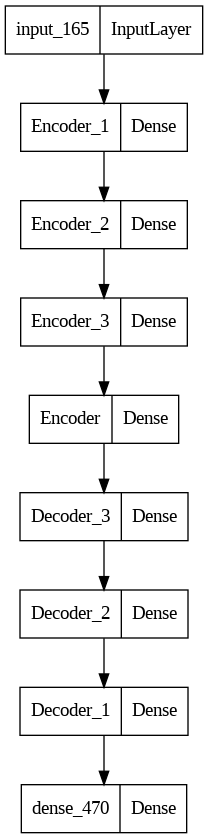

In [ ]:
plot_model(pipeline_autoencoder['autoencoder'].model_)

Se lleva a cabo la predicción por medio del modelo entrenado y el conjunto de datos de entrenamiento, lo cual permite reconstruir las imágenes de entrada (segunda fila) y compararlas con las originales (primera fila).

1/1 [==============================] - 0s 87ms/step


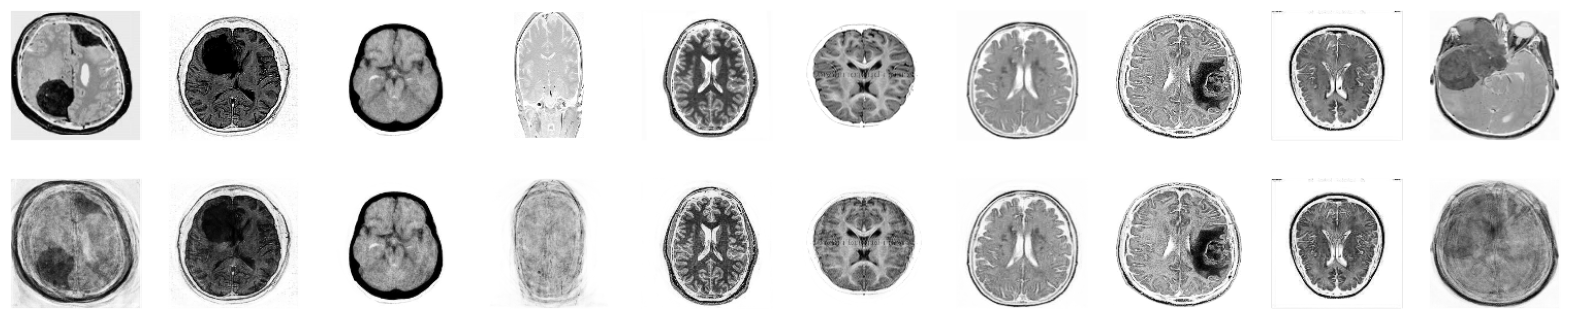

In [ ]:
predicted = pipeline_autoencoder['autoencoder'].model_.predict(X_train[:10])
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
for images, row in zip([X_train[:10], predicted], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((128, 128, 1)), cmap='gist_gray_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

Es indispensable analizar la capacidad de reconstrucción del autoencoder. La evidencia gráfica presentada en la figura anterior confirma la capacidad de la red neuronal para generar representaciones que son visualmente similares a las imágenes originales después de someterlas al proceso de codificación y decodificación (ubicadas en la fila inferior). No obstante, es esencial destacar que, durante la transición hacia un espacio latente de menor dimensión, se produce una pérdida de información perceptible. Dicha pérdida se manifiesta en la difuminación de las imágenes resultantes y, en ocasiones, en la omisión de detalles significativos (por ejemplo, en el TAC número 4 y 10).

### Búsqueda de Hiperparámetros

Una vez más, se han establecido los valores de los hiperparámetros que serán objeto de iteración, junto con la función objetivo que se busca maximizar. En esta ocasión, se ha optado por el negativo del Error Cuadrático Medio (MSE), dado que la tarea de reconstrucción de imágenes puede abordarse como una tarea de regresión. En adición a ello, se ha decidido utilizar una validación cruzada con cinco particiones. Con esta configuración definida, se prosigue con el entrenamiento de los modelos.

In [ ]:
param_search = {
    "autoencoder__n_layers": [1, 2, 3],
    "autoencoder__hidden_layer_1": [4096, 2048],
    "autoencoder__hidden_layer_2": [1024, 512],
    "autoencoder__hidden_layer_3": [456, 400],
    "autoencoder__encoder_layer": [300, 256],
    "autoencoder__activation": ["relu", "sigmoid"],
    "autoencoder__optimizer": ["adam", "sgd"],
    "autoencoder__optimizer__learning_rate": [0.001, 0.01, 0.1],
    "autoencoder__epochs": [50, 100, 150],
    "autoencoder__batch_size": [32],
}

search_autoencoder = RandomizedSearchCV(pipeline_autoencoder, param_search, cv=5, scoring='neg_mean_squared_error',
                                        verbose=2, n_iter=10, random_state=42)

In [ ]:
search_autoencoder.fit(X_train, X_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder_1 (Dense)           (None, 2048)              33556480  
                                                                 
 Encoder (Dense)             (None, 256)               524544    
                                                                 
 Decoder_1 (Dense)           (None, 2048)              526336    
                                                                 
 dense_471 (Dense)           (None, 16384)             33570816  
                                                                 
Total params: 68178176 (260.08 MB)
Trainable params: 68178176 (260.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
91/91 [==============================] - 2s 5ms/step - loss: 0.4913
Ep

91/91 [==============================] - 3s 5ms/step - loss: 0.4968
Epoch 2/100
91/91 [==============================] - 0s 5ms/step - loss: 0.4643
Epoch 3/100
91/91 [==============================] - 0s 5ms/step - loss: 0.4461
Epoch 4/100
91/91 [==============================] - 0s 5ms/step - loss: 0.4308
Epoch 5/100
91/91 [==============================] - 0s 5ms/step - loss: 0.4214
Epoch 6/100
91/91 [==============================] - 0s 5ms/step - loss: 0.4162
Epoch 7/100
91/91 [==============================] - 0s 5ms/step - loss: 0.4120
Epoch 8/100
91/91 [==============================] - 0s 5ms/step - loss: 0.4088
Epoch 9/100
91/91 [==============================] - 0s 5ms/step - loss: 0.4050
Epoch 10/100
91/91 [==============================] - 0s 5ms/step - loss: 0.4018
Epoch 11/100
91/91 [==============================] - 0s 5ms/step - loss: 0.3994
Epoch 12/100
91/91 [==============================] - 0s 5ms/step - loss: 0.3972
Epoch 13/100
91/91 [=============================

91/91 [==============================] - 2s 5ms/step - loss: 0.6933
Epoch 2/100
91/91 [==============================] - 0s 5ms/step - loss: 0.6932
Epoch 3/100
91/91 [==============================] - 0s 5ms/step - loss: 0.6932
Epoch 4/100
91/91 [==============================] - 0s 5ms/step - loss: 0.6931
Epoch 5/100
91/91 [==============================] - 0s 5ms/step - loss: 0.6931
Epoch 6/100
91/91 [==============================] - 0s 5ms/step - loss: 0.6930
Epoch 7/100
91/91 [==============================] - 0s 5ms/step - loss: 0.6930
Epoch 8/100
91/91 [==============================] - 0s 5ms/step - loss: 0.6929
Epoch 9/100
91/91 [==============================] - 0s 5ms/step - loss: 0.6929
Epoch 10/100
91/91 [==============================] - 0s 5ms/step - loss: 0.6929
Epoch 11/100
91/91 [==============================] - 0s 5ms/step - loss: 0.6928
Epoch 12/100
91/91 [==============================] - 0s 5ms/step - loss: 0.6928
Epoch 13/100
91/91 [=============================

91/91 [==============================] - 2s 6ms/step - loss: 0.7025
Epoch 2/100
91/91 [==============================] - 1s 6ms/step - loss: 0.6973
Epoch 3/100
91/91 [==============================] - 1s 6ms/step - loss: 0.6923
Epoch 4/100
91/91 [==============================] - 1s 6ms/step - loss: 0.6874
Epoch 5/100
91/91 [==============================] - 1s 6ms/step - loss: 0.6826
Epoch 6/100
91/91 [==============================] - 1s 6ms/step - loss: 0.6780
Epoch 7/100
91/91 [==============================] - 1s 6ms/step - loss: 0.6735
Epoch 8/100
91/91 [==============================] - 1s 6ms/step - loss: 0.6691
Epoch 9/100
91/91 [==============================] - 1s 6ms/step - loss: 0.6648
Epoch 10/100
91/91 [==============================] - 1s 6ms/step - loss: 0.6607
Epoch 11/100
91/91 [==============================] - 1s 6ms/step - loss: 0.6566
Epoch 12/100
91/91 [==============================] - 1s 6ms/step - loss: 0.6527
Epoch 13/100
91/91 [=============================

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder_1 (Dense)           (None, 4096)              67112960  
                                                                 
 Encoder_2 (Dense)           (None, 512)               2097664   
                                                                 
 Encoder_3 (Dense)           (None, 400)               205200    
                                                                 
 Encoder (Dense)             (None, 256)               102656    
                                                                 
 Decoder_3 (Dense)           (None, 400)               102800    
                                                                 
 Decoder_2 (Dense)           (None, 512)               205312    
                                                                 
 Decoder_1 (Dense)           (None, 4096)              

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder_1 (Dense)           (None, 4096)              67112960  
                                                                 
 Encoder_2 (Dense)           (None, 512)               2097664   
                                                                 
 Encoder_3 (Dense)           (None, 400)               205200    
                                                                 
 Encoder (Dense)             (None, 256)               102656    
                                                                 
 Decoder_3 (Dense)           (None, 400)               102800    
                                                                 
 Decoder_2 (Dense)           (None, 512)               205312    
                                                                 
 Decoder_1 (Dense)           (None, 4096)              

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder_1 (Dense)           (None, 2048)              33556480  
                                                                 
 Encoder_2 (Dense)           (None, 512)               1049088   
                                                                 
 Encoder (Dense)             (None, 300)               153900    
                                                                 
 Decoder_2 (Dense)           (None, 512)               154112    
                                                                 
 Decoder_1 (Dense)           (None, 2048)              1050624   
                                                                 
 dense_494 (Dense)           (None, 16384)             33570816  
                                                                 
Total params: 69535020 (265.26 MB)
Trainable params: 69

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder_1 (Dense)           (None, 2048)              33556480  
                                                                 
 Encoder (Dense)             (None, 300)               614700    
                                                                 
 Decoder_1 (Dense)           (None, 2048)              616448    
                                                                 
 dense_498 (Dense)           (None, 16384)             33570816  
                                                                 
Total params: 68358444 (260.77 MB)
Trainable params: 68358444 (260.77 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
91/91 [==============================] - 1s 5ms/step - loss: 0.6989
Epoch 2/100
91/91 [==============================] - 0s 5ms/ste

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder_1 (Dense)           (None, 2048)              33556480  
                                                                 
 Encoder_2 (Dense)           (None, 512)               1049088   
                                                                 
 Encoder (Dense)             (None, 256)               131328    
                                                                 
 Decoder_2 (Dense)           (None, 512)               131584    
                                                                 
 Decoder_1 (Dense)           (None, 2048)              1050624   
                                                                 
 dense_503 (Dense)           (None, 16384)             33570816  
                                                                 
Total params: 69489920 (265.08 MB)
Trainable params: 69

91/91 [==============================] - 2s 6ms/step - loss: 0.6930
Epoch 2/100
91/91 [==============================] - 1s 6ms/step - loss: 0.6924
Epoch 3/100
91/91 [==============================] - 1s 6ms/step - loss: 0.6909
Epoch 4/100
91/91 [==============================] - 1s 6ms/step - loss: 0.6858
Epoch 5/100
91/91 [==============================] - 1s 6ms/step - loss: 0.6607
Epoch 6/100
91/91 [==============================] - 1s 6ms/step - loss: 0.5830
Epoch 7/100
91/91 [==============================] - 1s 6ms/step - loss: 0.5313
Epoch 8/100
91/91 [==============================] - 1s 6ms/step - loss: 0.5190
Epoch 9/100
91/91 [==============================] - 1s 6ms/step - loss: 0.5113
Epoch 10/100
91/91 [==============================] - 1s 7ms/step - loss: 0.5047
Epoch 11/100
91/91 [==============================] - 1s 6ms/step - loss: 0.5000
Epoch 12/100
91/91 [==============================] - 1s 6ms/step - loss: 0.4971
Epoch 13/100
91/91 [=============================

91/91 [==============================] - 2s 6ms/step - loss: 0.6930
Epoch 2/100
91/91 [==============================] - 1s 6ms/step - loss: 0.6923
Epoch 3/100
91/91 [==============================] - 1s 6ms/step - loss: 0.6903
Epoch 4/100
91/91 [==============================] - 1s 6ms/step - loss: 0.6825
Epoch 5/100
91/91 [==============================] - 1s 6ms/step - loss: 0.6433
Epoch 6/100
91/91 [==============================] - 1s 6ms/step - loss: 0.5618
Epoch 7/100
91/91 [==============================] - 1s 6ms/step - loss: 0.5271
Epoch 8/100
91/91 [==============================] - 1s 6ms/step - loss: 0.5177
Epoch 9/100
91/91 [==============================] - 1s 6ms/step - loss: 0.5107
Epoch 10/100
91/91 [==============================] - 1s 6ms/step - loss: 0.5045
Epoch 11/100
91/91 [==============================] - 1s 6ms/step - loss: 0.5004
Epoch 12/100
91/91 [==============================] - 1s 6ms/step - loss: 0.4979
Epoch 13/100
91/91 [=============================

91/91 [==============================] - 1s 12ms/step - loss: 0.6924
Epoch 19/100
91/91 [==============================] - 0s 5ms/step - loss: 0.6923
Epoch 20/100
91/91 [==============================] - 0s 5ms/step - loss: 0.6922
Epoch 21/100
91/91 [==============================] - 0s 5ms/step - loss: 0.6921
Epoch 22/100
91/91 [==============================] - 0s 5ms/step - loss: 0.6920
Epoch 23/100
91/91 [==============================] - 0s 5ms/step - loss: 0.6919
Epoch 24/100
91/91 [==============================] - 0s 5ms/step - loss: 0.6918
Epoch 25/100
91/91 [==============================] - 0s 5ms/step - loss: 0.6917
Epoch 26/100
91/91 [==============================] - 0s 5ms/step - loss: 0.6915
Epoch 27/100
91/91 [==============================] - 0s 5ms/step - loss: 0.6913
Epoch 28/100
91/91 [==============================] - 0s 5ms/step - loss: 0.6912
Epoch 29/100
91/91 [==============================] - 0s 5ms/step - loss: 0.6910
Epoch 30/100
91/91 [====================

23/23 [==============================] - 0s 2ms/step
[CV] END autoencoder__activation=sigmoid, autoencoder__batch_size=32, autoencoder__encoder_layer=300, autoencoder__epochs=100, autoencoder__hidden_layer_1=2048, autoencoder__hidden_layer_2=1024, autoencoder__hidden_layer_3=400, autoencoder__n_layers=1, autoencoder__optimizer=adam, autoencoder__optimizer__learning_rate=0.1; total time=  10.2s
Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder_1 (Dense)           (None, 2048)              33556480  
                                                                 
 Encoder (Dense)             (None, 300)               614700    
                                                                 
 Decoder_1 (Dense)           (None, 2048)              616448    
                                                                 
 dense_519 (Dense)           (None, 16384)            

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('autoencoder',
                                              KerasRegressor(activation='relu', batch_size=32, callbacks=[[<keras.src.callbacks.EarlyStopping object at 0x7c607c6fa800>]], encoder_layer=256, epochs=50, hidden_layer_1=4096, hidden_layer_2=1024, hidden_layer_3=512, loss='binary_crossentropy', model=<function get_autoencoder at 0x7c60ffbaa950>, n_la...
                                        'autoencoder__encoder_layer': [300,
                                                                       256],
                                        'autoencoder__epochs': [100],
                                        'autoencoder__hidden_layer_1': [4096,
                                                                        2048],
                                        'autoencoder__hidden_layer_2': [1024,
                                                                        512],
                                        'autoencoder__hidden_layer_3': [456,
                                                                        400],
                                        'autoencoder__n_layers': [1, 2, 3],
                                        'autoencoder__optimizer': ['adam',
                                                                   'sgd'],
                                        'autoencoder__optimizer__learning_rate': [0.001,
                                                                                  0.01,
                                                                                  0.1]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [ ]:
best_model_autoencoder = search_autoencoder.best_estimator_['autoencoder'].model_
best_model_autoencoder.save('/content/models/best_autoencoder.h5')

In [ ]:
best_model_autoencoder = tf.keras.models.load_model('/content/models/best_autoencoder.h5')
search_autoencoder.best_params_

{'autoencoder__optimizer__learning_rate': 0.001,
 'autoencoder__optimizer': 'adam',
 'autoencoder__n_layers': 1,
 'autoencoder__hidden_layer_3': 400,
 'autoencoder__hidden_layer_2': 1024,
 'autoencoder__hidden_layer_1': 2048,
 'autoencoder__epochs': 100,
 'autoencoder__encoder_layer': 256,
 'autoencoder__batch_size': 32,
 'autoencoder__activation': 'relu'}

### Validación

Utilizando el modelo óptimo encontrado mediante la búsqueda de hiperparámetros, se reproducen 10 ejemplos extraídos del conjunto de imágenes de entrenamiento. Se puede observar una gran mejoría en comparación con los resultados obtenidos anteriormente. En gran parte de las imágenes ya no se nota la difuminación mencionada, por lo que ahora el proceso de codificación extrae las características más importantes de cada imagen de modo apropiado.








1/1 [==============================] - 0s 59ms/step


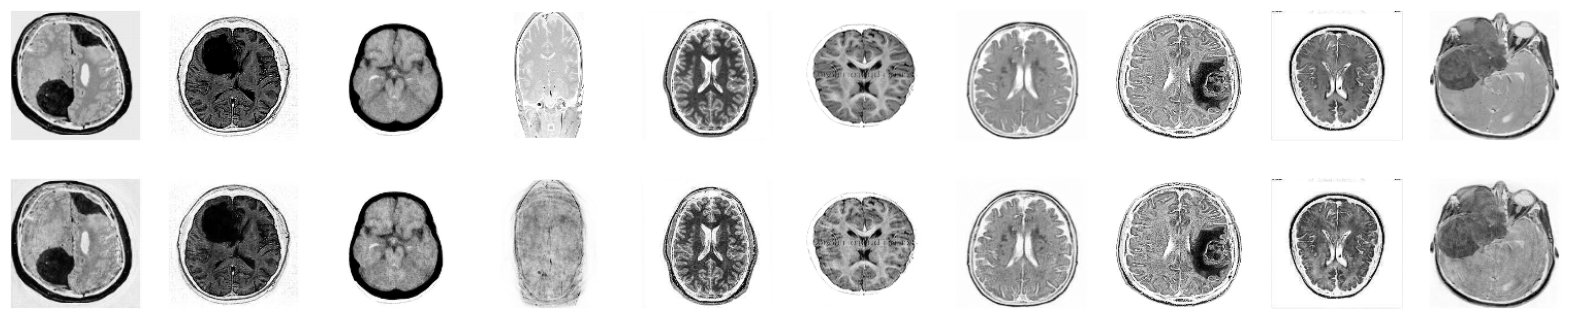

In [ ]:
predicted = best_model_autoencoder.predict(X_train[:10])
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
for images, row in zip([X_train[:10], predicted], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((128, 128, 1)), cmap='gist_gray_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

### Transferencia de conocimiento

Una de las capacidades fundamentales de las redes neuronales es la transferencia de conocimiento, capacidad que se consigue valiéndose de redes preentrenadas que pueden ser reutilizadas de acuerdo con los requerimientos. Tal utilidad facilita el adaptar un modelo a un contexto específico sin la necesidad de realizar un reentrenamiento completo de todos los parámetros disponibles. Para lograrlo, se aplica una técnica de "congelación" en las capas encargadas de la codificación, las cuales se aíslan de un autoencoder ya construido y validado.

In [ ]:
encoder = Sequential(name="Encoder")
for layers in best_model_autoencoder.layers:
    if "Decoder" in layers.name:
        break
    layers.trainable = False
    encoder.add(layers)

In [ ]:
new_encoder = Sequential(name='Prueba_Codificacion')

new_encoder.add(Input(shape=(X_train.shape[1]), name='Input_Layer'))
new_encoder.add(encoder)

new_encoder.summary()

Model: "Prueba_Codificacion"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
Total params: 34081024 (130.01 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 34081024 (130.01 MB)
_________________________________________________________________


10/10 [==============================] - 0s 1ms/step


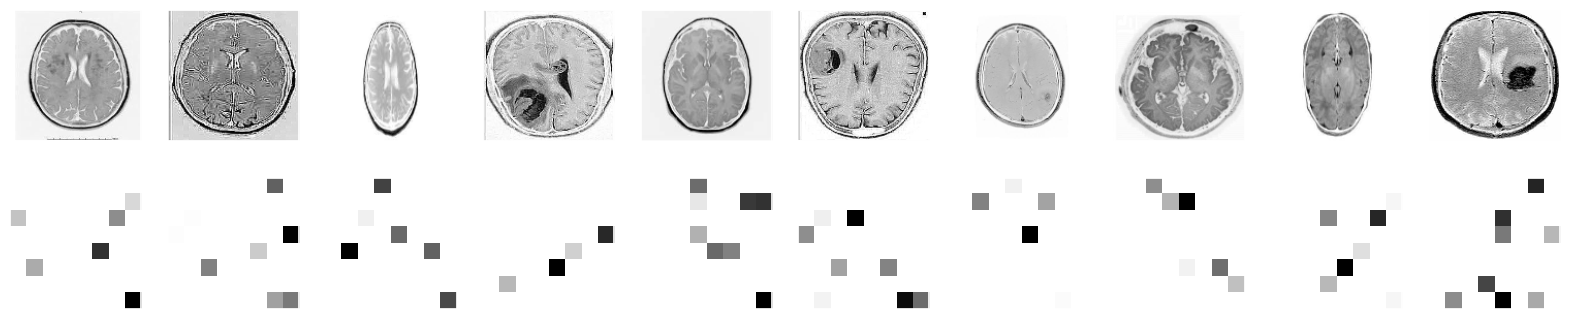

In [ ]:
predicted = new_encoder.predict(X_test[:10], batch_size=1)

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=False, sharey=False, figsize=(20,4))

for images, row in zip([X_test[:10].reshape((-1, 128, 128, 1)), predicted.reshape((-1, 8, 8))], axes):
    for img, ax in zip(images, row):
        ax.imshow(img, cmap='gist_gray_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

# La segunda fila, lo que predice, es el espacio latente: son los píxeles que representan características más importantes

En el caso de estudio, el codificador reduce la dimensionalidad de los datos de entrada pasando de 16384 a 256, lo que resulta en la obtención de una representación comprimida que captura las características o factores ocultos más sobresalientes (fila inferior).

## Clasificador

A partir del autoencoder seleccionado, se procede a implementar el proceso de construcción del clasificador valiéndose de las características recuperadas del nuevo espacio de representación. Para llevar a cabo este proceso, se implementa una función que acepta como argumentos los hiperparámetros requeridos. En esta función, se conforma un modelo que se cimienta sobre las capas del codificador, las cuales se ajustaron para que sus pesos no sean susceptibles de modificaciones durante el proceso de entrenamiento (layers.trainable = False). Las capas del _encoder_ son esenciales en el funcionamiento del clasificador, puesto que son responsables de proyectar las imágenes originales en el espacio latente.

La red neuronal base empleada como punto de partida consta de dos capas ocultas que siguen al _encoder_, compuestas por 25 neuronas cada una. Intercaladas, se incorporan dos capas de _dropout_ con una probabilidad de 0.3 y 0.2, respectivamente. Además, se fija la función de activación sigmoide en ambos casos. Por último, se inicializa el correspondiente _pipeline_ de procesamiento de datos y se entrena.

In [ ]:
def get_classifier_2 (meta, n_layers, activation, hidden_layer_1, dropout_1, hidden_layer_2 = None, dropout_2 = None):
    n_features_in_ = meta["n_features_in_"]
    classifier_model = Sequential(name="Perceptron_Multicapa_2")
    classifier_model.add(Input(shape=(n_features_in_,)))
    classifier_model.add(encoder)

    hidden_neurons = [hidden_layer_1, hidden_layer_2]
    dropouts = [dropout_1, dropout_2]

    for i in range(n_layers):
        classifier_model.add(Dense(hidden_neurons[i], activation=activation))
        classifier_model.add(Dropout(dropouts[i]))

     # Se cuenta con dos clases (según la presencia o ausencia de tumor)
    classifier_model.add(Dense(2, activation='softmax'))
    classifier_model.summary()
    return classifier_model

In [ ]:
classifier_model_2 = KerasClassifier(
    get_classifier_2,
    loss = "sparse_categorical_crossentropy",
    callbacks = model_callbacks,
    batch_size = 32,
    epochs = 50,
    optimizer = 'adam',
    n_layers = 2,
    hidden_layer_1 = 25,
    dropout_1 = 0.3,
    hidden_layer_2 = 25,
    dropout_2 = 0.2,
    metrics = ["accuracy"],
    activation = "sigmoid",
)

In [ ]:
pipeline_classifier_2 = Pipeline([('classifier_2', classifier_model_2)])

In [ ]:
pipeline_classifier_2.fit(X_train, Y_train)

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_522 (Dense)           (None, 25)                6425      
                                                                 
 dropout_306 (Dropout)       (None, 25)                0         
                                                                 
 dense_523 (Dense)           (None, 25)                650       
                                                                 
 dropout_307 (Dropout)       (None, 25)                0         
                                                                 
 dense_524 (Dense)           (None, 2)                 52        
                                                                 
Total params: 34088151 (130.04 MB)
Trainable

Pipeline(steps=[('classifier_2',
                 KerasClassifier(activation='sigmoid', batch_size=32, callbacks=[<keras.src.callbacks.EarlyStopping object at 0x7c62441520b0>], dropout_1=0.3, dropout_2=0.2, epochs=50, hidden_layer_1=25, hidden_layer_2=25, loss='sparse_categorical_crossentropy', metrics=['accuracy'], model=<function get_classifier_2 at 0x7c60446029e0>, n_layers=2, optimizer='adam'))])

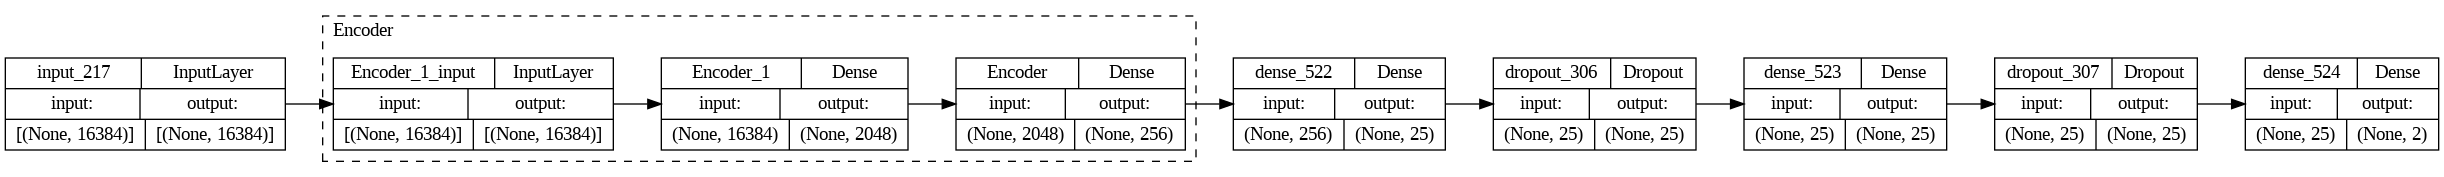

In [ ]:
plot_model(pipeline_classifier_2['classifier_2'].model_, show_shapes=True, rankdir='LR', expand_nested=True)

In [ ]:
pipeline_classifier_2['classifier_2'].model_.save('/content/models/classifier_base_2.h5')
pipeline_classifier_2['classifier_2'].model_ = tf.keras.models.load_model('/content/models/classifier_base_2.h5')

### Validación

In [ ]:
y_pred = pipeline_classifier_2['classifier_2'].model_.predict(X_train).argmax(axis=-1)
print(classification_report(Y_train, y_pred))

113/113 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1940
           1       0.98      0.97      0.98      1670

    accuracy                           0.98      3610
   macro avg       0.98      0.98      0.98      3610
weighted avg       0.98      0.98      0.98      3610



In [ ]:
y_pred = pipeline_classifier_2['classifier_2'].model_.predict(X_test).argmax(axis=-1)
print(classification_report(Y_test, y_pred))

29/29 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       487
           1       0.97      0.93      0.95       417

    accuracy                           0.95       904
   macro avg       0.96      0.95      0.95       904
weighted avg       0.96      0.95      0.95       904



Como se puede observar, simplemente con haber agregado el _encoder_ antes de ejecutar la tarea de clasificación, los resultados son más satisfactorios que los obtenidos con el primer clasificador, incluso con una significativa reducción en el número de neuronas totales. Lo anterior se puede corroborar en que, sin necesidad de realizar un búsqueda de hiperparámetros, se obtuvieron todas las métricas por encima del 90%, independiente de si la predicción se llevó a cabo sobre la partición de entrenamiento o sobre la de prueba. Adicionalmente, se cuenta con un _accuracy_ del 98% para _Y\_train_ y del 95% para _Y\_test_.

### Búsqueda de hiperparámetros

A pesar de que las métricas en el reporte de clasificación previo reflejan un nivel aceptable de desempeño, es posible que la arquitectura de base seleccionada no sea la óptima para la tarea específica en cuestión. Por lo tanto, se opta por efectuar la afinación de hiperparámetros mediante una búsqueda aleatoria que emplea validación cruzada para identificar el mejor modelo posible. Es importante destacar que los parámetros utilizados en esta búsqueda se determinan de la misma manera que en las ejecuciones previas.

In [ ]:
param_search = {
    "classifier_2__n_layers": [1, 2],
    "classifier_2__hidden_layer_1": [25, 50, 100],
    "classifier_2__hidden_layer_2": [25, 50, 100],
    "classifier_2__dropout_1": [0.1, 0.2, 0.3],
    "classifier_2__dropout_2": [0.1, 0.2, 0.3],
    "classifier_2__activation": ["relu", "sigmoid"],
    "classifier_2__optimizer": ["adam", "sgd"],
    "classifier_2__optimizer__learning_rate": [0.0001, 0.001, 0.1],
    "classifier_2__epochs": [50, 100, 150],
    "classifier_2__loss": ["sparse_categorical_crossentropy"],

}

search_classifier_2 = RandomizedSearchCV(pipeline_classifier_2, param_search, cv=5, scoring='accuracy', verbose=2, n_iter=100, random_state=42)

In [ ]:
search_classifier_2.fit(X_train, Y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_596 (Dense)           (None, 50)                12850     
                                                                 
 dropout_347 (Dropout)       (None, 50)                0         
                                                                 
 dense_597 (Dense)           (None, 2)                 102       
                                                                 
Total params: 34093976 (130.06 MB)
Trainable params: 12952 (50.59 KB)
Non-trainable params: 34081024 (130.01 MB)
_________________________________________________________________
Epoch 1/150
91/91 [==============================] - 1s 3ms/step -

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_604 (Dense)           (None, 50)                12850     
                                                                 
 dropout_351 (Dropout)       (None, 50)                0         
                                                                 
 dense_605 (Dense)           (None, 2)                 102       
                                                                 
Total params: 34093976 (130.06 MB)
Trainable params: 12952 (50.59 KB)
Non-trainable params: 34081024 (130.01 MB)
_________________________________________________________________
Epoch 1/150
91/91 [==============================] - 1s 3ms/step - loss: 0.6233 - accuracy: 0.6898
Epoch 2/150
91/91 [===========

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_614 (Dense)           (None, 50)                12850     
                                                                 
 dropout_356 (Dropout)       (None, 50)                0         
                                                                 
 dense_615 (Dense)           (None, 2)                 102       
                                                                 
Total params: 34093976 (130.06 MB)
Trainable params: 12952 (50.59 KB)
Non-trainable params: 34081024 (130.01 MB)
_________________________________________________________________
Epoch 1/100
91/91 [==============================] - 1s 3ms/step - loss: 1.2145 - accuracy: 0.4754
Epoch 2/100
91/91 [===========

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_628 (Dense)           (None, 50)                12850     
                                                                 
 dropout_365 (Dropout)       (None, 50)                0         
                                                                 
 dense_629 (Dense)           (None, 25)                1275      
                                                                 
 dropout_366 (Dropout)       (None, 25)                0         
                                                                 
 dense_630 (Dense)           (None, 2)                 52        
                                                                 
Total params: 34095201 (130.06 MB)
Trainable

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_643 (Dense)           (None, 50)                12850     
                                                                 
 dropout_375 (Dropout)       (None, 50)                0         
                                                                 
 dense_644 (Dense)           (None, 100)               5100      
                                                                 
 dropout_376 (Dropout)       (None, 100)               0         
                                                                 
 dense_645 (Dense)           (None, 2)                 202       
                                                                 
Total params: 34099176 (130.08 MB)
Trainable

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_654 (Dense)           (None, 25)                6425      
                                                                 
 dropout_381 (Dropout)       (None, 25)                0         
                                                                 
 dense_655 (Dense)           (None, 2)                 52        
                                                                 
Total params: 34087501 (130.03 MB)
Trainable params: 6477 (25.30 KB)
Non-trainable params: 34081024 (130.01 MB)
_________________________________________________________________
Epoch 1/100
91/91 [==============================] - 1s 3ms/step - loss: 0.5985 - accuracy: 0.6672
Epoch 2/100
91/91 [============

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_668 (Dense)           (None, 100)               25700     
                                                                 
 dropout_390 (Dropout)       (None, 100)               0         
                                                                 
 dense_669 (Dense)           (None, 25)                2525      
                                                                 
 dropout_391 (Dropout)       (None, 25)                0         
                                                                 
 dense_670 (Dense)           (None, 2)                 52        
                                                                 
Total params: 34109301 (130.12 MB)
Trainable

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_683 (Dense)           (None, 50)                12850     
                                                                 
 dropout_400 (Dropout)       (None, 50)                0         
                                                                 
 dense_684 (Dense)           (None, 50)                2550      
                                                                 
 dropout_401 (Dropout)       (None, 50)                0         
                                                                 
 dense_685 (Dense)           (None, 2)                 102       
                                                                 
Total params: 34096526 (130.07 MB)
Trainable

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_698 (Dense)           (None, 25)                6425      
                                                                 
 dropout_410 (Dropout)       (None, 25)                0         
                                                                 
 dense_699 (Dense)           (None, 25)                650       
                                                                 
 dropout_411 (Dropout)       (None, 25)                0         
                                                                 
 dense_700 (Dense)           (None, 2)                 52        
                                                                 
Total params: 34088151 (130.04 MB)
Trainable

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_713 (Dense)           (None, 50)                12850     
                                                                 
 dropout_420 (Dropout)       (None, 50)                0         
                                                                 
 dense_714 (Dense)           (None, 25)                1275      
                                                                 
 dropout_421 (Dropout)       (None, 25)                0         
                                                                 
 dense_715 (Dense)           (None, 2)                 52        
                                                                 
Total params: 34095201 (130.06 MB)
Trainable

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_728 (Dense)           (None, 100)               25700     
                                                                 
 dropout_430 (Dropout)       (None, 100)               0         
                                                                 
 dense_729 (Dense)           (None, 100)               10100     
                                                                 
 dropout_431 (Dropout)       (None, 100)               0         
                                                                 
 dense_730 (Dense)           (None, 2)                 202       
                                                                 
Total params: 34117026 (130.15 MB)
Trainable

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_743 (Dense)           (None, 25)                6425      
                                                                 
 dropout_440 (Dropout)       (None, 25)                0         
                                                                 
 dense_744 (Dense)           (None, 25)                650       
                                                                 
 dropout_441 (Dropout)       (None, 25)                0         
                                                                 
 dense_745 (Dense)           (None, 2)                 52        
                                                                 
Total params: 34088151 (130.04 MB)
Trainable

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_754 (Dense)           (None, 50)                12850     
                                                                 
 dropout_446 (Dropout)       (None, 50)                0         
                                                                 
 dense_755 (Dense)           (None, 2)                 102       
                                                                 
Total params: 34093976 (130.06 MB)
Trainable params: 12952 (50.59 KB)
Non-trainable params: 34081024 (130.01 MB)
_________________________________________________________________
Epoch 1/100
91/91 [==============================] - 1s 3ms/step - loss: 0.5939 - accuracy: 0.6745
Epoch 2/100
91/91 [===========

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_766 (Dense)           (None, 100)               25700     
                                                                 
 dropout_452 (Dropout)       (None, 100)               0         
                                                                 
 dense_767 (Dense)           (None, 25)                2525      
                                                                 
 dropout_453 (Dropout)       (None, 25)                0         
                                                                 
 dense_768 (Dense)           (None, 2)                 52        
                                                                 
Total params: 34109301 (130.12 MB)
Trainable

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_781 (Dense)           (None, 50)                12850     
                                                                 
 dropout_462 (Dropout)       (None, 50)                0         
                                                                 
 dense_782 (Dense)           (None, 100)               5100      
                                                                 
 dropout_463 (Dropout)       (None, 100)               0         
                                                                 
 dense_783 (Dense)           (None, 2)                 202       
                                                                 
Total params: 34099176 (130.08 MB)
Trainable

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_796 (Dense)           (None, 100)               25700     
                                                                 
 dropout_472 (Dropout)       (None, 100)               0         
                                                                 
 dense_797 (Dense)           (None, 25)                2525      
                                                                 
 dropout_473 (Dropout)       (None, 25)                0         
                                                                 
 dense_798 (Dense)           (None, 2)                 52        
                                                                 
Total params: 34109301 (130.12 MB)
Trainable

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_811 (Dense)           (None, 100)               25700     
                                                                 
 dropout_482 (Dropout)       (None, 100)               0         
                                                                 
 dense_812 (Dense)           (None, 25)                2525      
                                                                 
 dropout_483 (Dropout)       (None, 25)                0         
                                                                 
 dense_813 (Dense)           (None, 2)                 52        
                                                                 
Total params: 34109301 (130.12 MB)
Trainable

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_826 (Dense)           (None, 25)                6425      
                                                                 
 dropout_492 (Dropout)       (None, 25)                0         
                                                                 
 dense_827 (Dense)           (None, 100)               2600      
                                                                 
 dropout_493 (Dropout)       (None, 100)               0         
                                                                 
 dense_828 (Dense)           (None, 2)                 202       
                                                                 
Total params: 34090251 (130.04 MB)
Trainable

91/91 [==============================] - 1s 12ms/step - loss: 0.7539 - accuracy: 0.5270
Epoch 15/50
91/91 [==============================] - 0s 3ms/step - loss: 0.7429 - accuracy: 0.5305
Epoch 16/50
91/91 [==============================] - 0s 3ms/step - loss: 0.7567 - accuracy: 0.5267
Epoch 16: early stopping
23/23 [==============================] - 0s 2ms/step
[CV] END classifier_2__activation=sigmoid, classifier_2__dropout_1=0.3, classifier_2__dropout_2=0.3, classifier_2__epochs=50, classifier_2__hidden_layer_1=100, classifier_2__hidden_layer_2=50, classifier_2__loss=sparse_categorical_crossentropy, classifier_2__n_layers=1, classifier_2__optimizer=sgd, classifier_2__optimizer__learning_rate=0.0001; total time=   6.5s
Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                        

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_854 (Dense)           (None, 100)               25700     
                                                                 
 dropout_509 (Dropout)       (None, 100)               0         
                                                                 
 dense_855 (Dense)           (None, 100)               10100     
                                                                 
 dropout_510 (Dropout)       (None, 100)               0         
                                                                 
 dense_856 (Dense)           (None, 2)                 202       
                                                                 
Total params: 34117026 (130.15 MB)
Trainable

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_868 (Dense)           (None, 25)                6425      
                                                                 
 dropout_518 (Dropout)       (None, 25)                0         
                                                                 
 dense_869 (Dense)           (None, 2)                 52        
                                                                 
Total params: 34087501 (130.03 MB)
Trainable params: 6477 (25.30 KB)
Non-trainable params: 34081024 (130.01 MB)
_________________________________________________________________
Epoch 1/100
91/91 [==============================] - 1s 3ms/step - loss: 0.8878 - accuracy: 0.6375
Epoch 2/100
91/91 [============

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_880 (Dense)           (None, 50)                12850     
                                                                 
 dropout_524 (Dropout)       (None, 50)                0         
                                                                 
 dense_881 (Dense)           (None, 2)                 102       
                                                                 
Total params: 34093976 (130.06 MB)
Trainable params: 12952 (50.59 KB)
Non-trainable params: 34081024 (130.01 MB)
_________________________________________________________________
Epoch 1/100
91/91 [==============================] - 1s 3ms/step - loss: 0.7688 - accuracy: 0.5436
Epoch 2/100
91/91 [===========

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_890 (Dense)           (None, 50)                12850     
                                                                 
 dropout_529 (Dropout)       (None, 50)                0         
                                                                 
 dense_891 (Dense)           (None, 2)                 102       
                                                                 
Total params: 34093976 (130.06 MB)
Trainable params: 12952 (50.59 KB)
Non-trainable params: 34081024 (130.01 MB)
_________________________________________________________________
Epoch 1/50
91/91 [==============================] - 1s 3ms/step - loss: 0.7676 - accuracy: 0.6416
Epoch 2/50
91/91 [=============

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_902 (Dense)           (None, 50)                12850     
                                                                 
 dropout_536 (Dropout)       (None, 50)                0         
                                                                 
 dense_903 (Dense)           (None, 100)               5100      
                                                                 
 dropout_537 (Dropout)       (None, 100)               0         
                                                                 
 dense_904 (Dense)           (None, 2)                 202       
                                                                 
Total params: 34099176 (130.08 MB)
Trainable

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_915 (Dense)           (None, 50)                12850     
                                                                 
 dropout_544 (Dropout)       (None, 50)                0         
                                                                 
 dense_916 (Dense)           (None, 2)                 102       
                                                                 
Total params: 34093976 (130.06 MB)
Trainable params: 12952 (50.59 KB)
Non-trainable params: 34081024 (130.01 MB)
_________________________________________________________________
Epoch 1/100
91/91 [==============================] - 1s 3ms/step - loss: 0.6569 - accuracy: 0.6530
Epoch 2/100
91/91 [===========

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_927 (Dense)           (None, 25)                6425      
                                                                 
 dropout_550 (Dropout)       (None, 25)                0         
                                                                 
 dense_928 (Dense)           (None, 2)                 52        
                                                                 
Total params: 34087501 (130.03 MB)
Trainable params: 6477 (25.30 KB)
Non-trainable params: 34081024 (130.01 MB)
_________________________________________________________________
Epoch 1/100
91/91 [==============================] - 1s 3ms/step - loss: 0.7335 - accuracy: 0.5298
Epoch 2/100
91/91 [============

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_937 (Dense)           (None, 100)               25700     
                                                                 
 dropout_555 (Dropout)       (None, 100)               0         
                                                                 
 dense_938 (Dense)           (None, 2)                 202       
                                                                 
Total params: 34106926 (130.11 MB)
Trainable params: 25902 (101.18 KB)
Non-trainable params: 34081024 (130.01 MB)
_________________________________________________________________
Epoch 1/150
91/91 [==============================] - 1s 3ms/step - loss: 0.8449 - accuracy: 0.5173
Epoch 2/150
91/91 [==========

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_949 (Dense)           (None, 100)               25700     
                                                                 
 dropout_561 (Dropout)       (None, 100)               0         
                                                                 
 dense_950 (Dense)           (None, 2)                 202       
                                                                 
Total params: 34106926 (130.11 MB)
Trainable params: 25902 (101.18 KB)
Non-trainable params: 34081024 (130.01 MB)
_________________________________________________________________
Epoch 1/50
91/91 [==============================] - 1s 3ms/step - loss: 0.9934 - accuracy: 0.5405
Epoch 2/50
91/91 [============

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_959 (Dense)           (None, 100)               25700     
                                                                 
 dropout_566 (Dropout)       (None, 100)               0         
                                                                 
 dense_960 (Dense)           (None, 2)                 202       
                                                                 
Total params: 34106926 (130.11 MB)
Trainable params: 25902 (101.18 KB)
Non-trainable params: 34081024 (130.01 MB)
_________________________________________________________________
Epoch 1/100
91/91 [==============================] - 1s 3ms/step - loss: 0.7581 - accuracy: 0.5450
Epoch 2/100
91/91 [==========

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_973 (Dense)           (None, 25)                6425      
                                                                 
 dropout_575 (Dropout)       (None, 25)                0         
                                                                 
 dense_974 (Dense)           (None, 25)                650       
                                                                 
 dropout_576 (Dropout)       (None, 25)                0         
                                                                 
 dense_975 (Dense)           (None, 2)                 52        
                                                                 
Total params: 34088151 (130.04 MB)
Trainable

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_988 (Dense)           (None, 25)                6425      
                                                                 
 dropout_585 (Dropout)       (None, 25)                0         
                                                                 
 dense_989 (Dense)           (None, 100)               2600      
                                                                 
 dropout_586 (Dropout)       (None, 100)               0         
                                                                 
 dense_990 (Dense)           (None, 2)                 202       
                                                                 
Total params: 34090251 (130.04 MB)
Trainable

91/91 [==============================] - 2s 3ms/step - loss: 0.6154 - accuracy: 0.6922
Epoch 2/50
91/91 [==============================] - 0s 3ms/step - loss: 0.3992 - accuracy: 0.8303
Epoch 3/50
91/91 [==============================] - 0s 3ms/step - loss: 0.3104 - accuracy: 0.8729
Epoch 4/50
91/91 [==============================] - 0s 3ms/step - loss: 0.2255 - accuracy: 0.9117
Epoch 5/50
91/91 [==============================] - 0s 4ms/step - loss: 0.1905 - accuracy: 0.9269
Epoch 6/50
91/91 [==============================] - 0s 4ms/step - loss: 0.1434 - accuracy: 0.9467
Epoch 7/50
91/91 [==============================] - 0s 4ms/step - loss: 0.1249 - accuracy: 0.9567
Epoch 8/50
91/91 [==============================] - 0s 4ms/step - loss: 0.1038 - accuracy: 0.9664
Epoch 9/50
91/91 [==============================] - 0s 4ms/step - loss: 0.0869 - accuracy: 0.9744
Epoch 10/50
91/91 [==============================] - 0s 3ms/step - loss: 0.0754 - accuracy: 0.9768
Epoch 11/50
91/91 [===========

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1016 (Dense)          (None, 100)               25700     
                                                                 
 dropout_602 (Dropout)       (None, 100)               0         
                                                                 
 dense_1017 (Dense)          (None, 25)                2525      
                                                                 
 dropout_603 (Dropout)       (None, 25)                0         
                                                                 
 dense_1018 (Dense)          (None, 2)                 52        
                                                                 
Total params: 34109301 (130.12 MB)
Trainable

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1031 (Dense)          (None, 25)                6425      
                                                                 
 dropout_612 (Dropout)       (None, 25)                0         
                                                                 
 dense_1032 (Dense)          (None, 25)                650       
                                                                 
 dropout_613 (Dropout)       (None, 25)                0         
                                                                 
 dense_1033 (Dense)          (None, 2)                 52        
                                                                 
Total params: 34088151 (130.04 MB)
Trainable

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1049 (Dense)          (None, 25)                6425      
                                                                 
 dropout_624 (Dropout)       (None, 25)                0         
                                                                 
 dense_1050 (Dense)          (None, 25)                650       
                                                                 
 dropout_625 (Dropout)       (None, 25)                0         
                                                                 
 dense_1051 (Dense)          (None, 2)                 52        
                                                                 
Total params: 34088151 (130.04 MB)
Trainable

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1064 (Dense)          (None, 100)               25700     
                                                                 
 dropout_634 (Dropout)       (None, 100)               0         
                                                                 
 dense_1065 (Dense)          (None, 50)                5050      
                                                                 
 dropout_635 (Dropout)       (None, 50)                0         
                                                                 
 dense_1066 (Dense)          (None, 2)                 102       
                                                                 
Total params: 34111876 (130.13 MB)
Trainable

91/91 [==============================] - 1s 13ms/step - loss: 0.4921 - accuracy: 0.7503
Epoch 9/50
91/91 [==============================] - 0s 4ms/step - loss: 0.5003 - accuracy: 0.7600
Epoch 10/50
91/91 [==============================] - 0s 3ms/step - loss: 0.4930 - accuracy: 0.7472
Epoch 11/50
91/91 [==============================] - 0s 4ms/step - loss: 0.4889 - accuracy: 0.7479
Epoch 12/50
91/91 [==============================] - 0s 4ms/step - loss: 0.4818 - accuracy: 0.7490
Epoch 13/50
91/91 [==============================] - 0s 3ms/step - loss: 0.4780 - accuracy: 0.7628
Epoch 14/50
91/91 [==============================] - 0s 3ms/step - loss: 0.4719 - accuracy: 0.7708
Epoch 15/50
91/91 [==============================] - 0s 4ms/step - loss: 0.5203 - accuracy: 0.7358
Epoch 16/50
91/91 [==============================] - 0s 4ms/step - loss: 0.5231 - accuracy: 0.7195
Epoch 17/50
91/91 [==============================] - 0s 4ms/step - loss: 0.4923 - accuracy: 0.7417
Epoch 18/50
91/91 [===

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1097 (Dense)          (None, 100)               25700     
                                                                 
 dropout_656 (Dropout)       (None, 100)               0         
                                                                 
 dense_1098 (Dense)          (None, 25)                2525      
                                                                 
 dropout_657 (Dropout)       (None, 25)                0         
                                                                 
 dense_1099 (Dense)          (None, 2)                 52        
                                                                 
Total params: 34109301 (130.12 MB)
Trainable

Epoch 1/100
91/91 [==============================] - 1s 3ms/step - loss: 0.6168 - accuracy: 0.6690
Epoch 2/100
91/91 [==============================] - 0s 3ms/step - loss: 0.4860 - accuracy: 0.7735
Epoch 3/100
91/91 [==============================] - 0s 3ms/step - loss: 0.4112 - accuracy: 0.8151
Epoch 4/100
91/91 [==============================] - 0s 3ms/step - loss: 0.3547 - accuracy: 0.8518
Epoch 5/100
91/91 [==============================] - 0s 3ms/step - loss: 0.2855 - accuracy: 0.8864
Epoch 6/100
91/91 [==============================] - 0s 3ms/step - loss: 0.2811 - accuracy: 0.8958
Epoch 7/100
91/91 [==============================] - 0s 3ms/step - loss: 0.2452 - accuracy: 0.9103
Epoch 8/100
91/91 [==============================] - 0s 3ms/step - loss: 0.2160 - accuracy: 0.9127
Epoch 9/100
91/91 [==============================] - 0s 3ms/step - loss: 0.1978 - accuracy: 0.9287
Epoch 10/100
91/91 [==============================] - 0s 3ms/step - loss: 0.1573 - accuracy: 0.9449
Epoch 11/

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1127 (Dense)          (None, 100)               25700     
                                                                 
 dropout_675 (Dropout)       (None, 100)               0         
                                                                 
 dense_1128 (Dense)          (None, 2)                 202       
                                                                 
Total params: 34106926 (130.11 MB)
Trainable params: 25902 (101.18 KB)
Non-trainable params: 34081024 (130.01 MB)
_________________________________________________________________
Epoch 1/50
91/91 [==============================] - 1s 3ms/step - loss: 0.7216 - accuracy: 0.5149
Epoch 2/50
91/91 [============

91/91 [==============================] - 2s 3ms/step - loss: 0.9197 - accuracy: 0.5319
Epoch 2/100
91/91 [==============================] - 0s 3ms/step - loss: 0.8559 - accuracy: 0.5426
Epoch 3/100
91/91 [==============================] - 0s 3ms/step - loss: 0.8424 - accuracy: 0.5357
Epoch 4/100
91/91 [==============================] - 0s 3ms/step - loss: 0.8315 - accuracy: 0.5395
Epoch 5/100
91/91 [==============================] - 0s 3ms/step - loss: 0.8214 - accuracy: 0.5447
Epoch 6/100
91/91 [==============================] - 0s 3ms/step - loss: 0.8120 - accuracy: 0.5502
Epoch 7/100
91/91 [==============================] - 0s 3ms/step - loss: 0.7936 - accuracy: 0.5582
Epoch 8/100
91/91 [==============================] - 0s 3ms/step - loss: 0.7918 - accuracy: 0.5596
Epoch 9/100
91/91 [==============================] - 0s 3ms/step - loss: 0.7816 - accuracy: 0.5585
Epoch 10/100
91/91 [==============================] - 0s 3ms/step - loss: 0.7829 - accuracy: 0.5630
Epoch 11/100
91/91 [=

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1158 (Dense)          (None, 25)                6425      
                                                                 
 dropout_695 (Dropout)       (None, 25)                0         
                                                                 
 dense_1159 (Dense)          (None, 50)                1300      
                                                                 
 dropout_696 (Dropout)       (None, 50)                0         
                                                                 
 dense_1160 (Dense)          (None, 2)                 102       
                                                                 
Total params: 34088851 (130.04 MB)
Trainable

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1173 (Dense)          (None, 50)                12850     
                                                                 
 dropout_705 (Dropout)       (None, 50)                0         
                                                                 
 dense_1174 (Dense)          (None, 50)                2550      
                                                                 
 dropout_706 (Dropout)       (None, 50)                0         
                                                                 
 dense_1175 (Dense)          (None, 2)                 102       
                                                                 
Total params: 34096526 (130.07 MB)
Trainable

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1186 (Dense)          (None, 25)                6425      
                                                                 
 dropout_712 (Dropout)       (None, 25)                0         
                                                                 
 dense_1187 (Dense)          (None, 2)                 52        
                                                                 
Total params: 34087501 (130.03 MB)
Trainable params: 6477 (25.30 KB)
Non-trainable params: 34081024 (130.01 MB)
_________________________________________________________________
Epoch 1/50
91/91 [==============================] - 1s 3ms/step - loss: 1.3151 - accuracy: 0.5277
Epoch 2/50
91/91 [==============

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1199 (Dense)          (None, 50)                12850     
                                                                 
 dropout_719 (Dropout)       (None, 50)                0         
                                                                 
 dense_1200 (Dense)          (None, 50)                2550      
                                                                 
 dropout_720 (Dropout)       (None, 50)                0         
                                                                 
 dense_1201 (Dense)          (None, 2)                 102       
                                                                 
Total params: 34096526 (130.07 MB)
Trainable

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1214 (Dense)          (None, 50)                12850     
                                                                 
 dropout_729 (Dropout)       (None, 50)                0         
                                                                 
 dense_1215 (Dense)          (None, 25)                1275      
                                                                 
 dropout_730 (Dropout)       (None, 25)                0         
                                                                 
 dense_1216 (Dense)          (None, 2)                 52        
                                                                 
Total params: 34095201 (130.06 MB)
Trainable

91/91 [==============================] - 2s 3ms/step - loss: 1.7583 - accuracy: 0.6330
Epoch 2/50
91/91 [==============================] - 0s 3ms/step - loss: 0.5739 - accuracy: 0.6409
Epoch 3/50
91/91 [==============================] - 0s 3ms/step - loss: 0.5546 - accuracy: 0.6818
Epoch 4/50
91/91 [==============================] - 0s 3ms/step - loss: 0.5506 - accuracy: 0.6430
Epoch 5/50
91/91 [==============================] - 0s 3ms/step - loss: 0.5051 - accuracy: 0.6946
Epoch 6/50
91/91 [==============================] - 0s 3ms/step - loss: 0.4700 - accuracy: 0.6943
Epoch 7/50
91/91 [==============================] - 0s 3ms/step - loss: 0.4981 - accuracy: 0.7008
Epoch 8/50
91/91 [==============================] - 0s 3ms/step - loss: 0.4782 - accuracy: 0.7126
Epoch 9/50
91/91 [==============================] - 0s 3ms/step - loss: 0.4843 - accuracy: 0.7396
Epoch 10/50
91/91 [==============================] - 0s 3ms/step - loss: 0.5220 - accuracy: 0.6984
Epoch 11/50
91/91 [===========

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1242 (Dense)          (None, 100)               25700     
                                                                 
 dropout_746 (Dropout)       (None, 100)               0         
                                                                 
 dense_1243 (Dense)          (None, 25)                2525      
                                                                 
 dropout_747 (Dropout)       (None, 25)                0         
                                                                 
 dense_1244 (Dense)          (None, 2)                 52        
                                                                 
Total params: 34109301 (130.12 MB)
Trainable

Epoch 1/50
91/91 [==============================] - 1s 3ms/step - loss: 0.6304 - accuracy: 0.6745
Epoch 2/50
91/91 [==============================] - 0s 3ms/step - loss: 0.4493 - accuracy: 0.7770
Epoch 3/50
91/91 [==============================] - 0s 3ms/step - loss: 0.3979 - accuracy: 0.8092
Epoch 4/50
91/91 [==============================] - 0s 3ms/step - loss: 0.3467 - accuracy: 0.8431
Epoch 5/50
91/91 [==============================] - 0s 3ms/step - loss: 0.2967 - accuracy: 0.8636
Epoch 6/50
91/91 [==============================] - 0s 3ms/step - loss: 0.2787 - accuracy: 0.8833
Epoch 7/50
91/91 [==============================] - 0s 3ms/step - loss: 0.2533 - accuracy: 0.8965
Epoch 8/50
91/91 [==============================] - 0s 3ms/step - loss: 0.2454 - accuracy: 0.8937
Epoch 9/50
91/91 [==============================] - 0s 3ms/step - loss: 0.2372 - accuracy: 0.8961
Epoch 10/50
91/91 [==============================] - 0s 3ms/step - loss: 0.2226 - accuracy: 0.9030
Epoch 11/50
91/91 [

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1267 (Dense)          (None, 25)                6425      
                                                                 
 dropout_760 (Dropout)       (None, 25)                0         
                                                                 
 dense_1268 (Dense)          (None, 2)                 52        
                                                                 
Total params: 34087501 (130.03 MB)
Trainable params: 6477 (25.30 KB)
Non-trainable params: 34081024 (130.01 MB)
_________________________________________________________________
Epoch 1/150
91/91 [==============================] - 1s 3ms/step - loss: 1.1047 - accuracy: 0.5381
Epoch 2/150
91/91 [============

91/91 [==============================] - 3s 4ms/step - loss: 0.8592 - accuracy: 0.5357
Epoch 2/150
91/91 [==============================] - 0s 4ms/step - loss: 0.7704 - accuracy: 0.5672
Epoch 3/150
91/91 [==============================] - 0s 4ms/step - loss: 0.7106 - accuracy: 0.5938
Epoch 4/150
91/91 [==============================] - 0s 3ms/step - loss: 0.6491 - accuracy: 0.6434
Epoch 5/150
91/91 [==============================] - 0s 3ms/step - loss: 0.6452 - accuracy: 0.6440
Epoch 6/150
91/91 [==============================] - 0s 3ms/step - loss: 0.6117 - accuracy: 0.6610
Epoch 7/150
91/91 [==============================] - 0s 4ms/step - loss: 0.5970 - accuracy: 0.6839
Epoch 8/150
91/91 [==============================] - 0s 3ms/step - loss: 0.5721 - accuracy: 0.7012
Epoch 9/150
91/91 [==============================] - 0s 3ms/step - loss: 0.5533 - accuracy: 0.7178
Epoch 10/150
91/91 [==============================] - 0s 3ms/step - loss: 0.5530 - accuracy: 0.7199
Epoch 11/150
91/91 [=

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1294 (Dense)          (None, 25)                6425      
                                                                 
 dropout_776 (Dropout)       (None, 25)                0         
                                                                 
 dense_1295 (Dense)          (None, 2)                 52        
                                                                 
Total params: 34087501 (130.03 MB)
Trainable params: 6477 (25.30 KB)
Non-trainable params: 34081024 (130.01 MB)
_________________________________________________________________
Epoch 1/150
91/91 [==============================] - 1s 3ms/step - loss: 1.0879 - accuracy: 0.5059
Epoch 2/150
91/91 [============

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1311 (Dense)          (None, 50)                12850     
                                                                 
 dropout_787 (Dropout)       (None, 50)                0         
                                                                 
 dense_1312 (Dense)          (None, 100)               5100      
                                                                 
 dropout_788 (Dropout)       (None, 100)               0         
                                                                 
 dense_1313 (Dense)          (None, 2)                 202       
                                                                 
Total params: 34099176 (130.08 MB)
Trainable

91/91 [==============================] - 3s 3ms/step - loss: 0.6624 - accuracy: 0.5966
Epoch 2/100
91/91 [==============================] - 0s 3ms/step - loss: 0.5476 - accuracy: 0.7185
Epoch 3/100
91/91 [==============================] - 0s 3ms/step - loss: 0.4860 - accuracy: 0.7600
Epoch 4/100
91/91 [==============================] - 0s 3ms/step - loss: 0.4453 - accuracy: 0.7967
Epoch 5/100
91/91 [==============================] - 0s 3ms/step - loss: 0.4045 - accuracy: 0.8172
Epoch 6/100
91/91 [==============================] - 0s 3ms/step - loss: 0.3912 - accuracy: 0.8255
Epoch 7/100
91/91 [==============================] - 0s 3ms/step - loss: 0.3476 - accuracy: 0.8518
Epoch 8/100
91/91 [==============================] - 0s 4ms/step - loss: 0.3309 - accuracy: 0.8594
Epoch 9/100
91/91 [==============================] - 0s 4ms/step - loss: 0.2973 - accuracy: 0.8833
Epoch 10/100
91/91 [==============================] - 0s 3ms/step - loss: 0.2735 - accuracy: 0.8889
Epoch 11/100
91/91 [=

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1343 (Dense)          (None, 25)                6425      
                                                                 
 dropout_808 (Dropout)       (None, 25)                0         
                                                                 
 dense_1344 (Dense)          (None, 2)                 52        
                                                                 
Total params: 34087501 (130.03 MB)
Trainable params: 6477 (25.30 KB)
Non-trainable params: 34081024 (130.01 MB)
_________________________________________________________________
Epoch 1/150
91/91 [==============================] - 1s 3ms/step - loss: 0.8627 - accuracy: 0.5630
Epoch 2/150
91/91 [============

91/91 [==============================] - 1s 13ms/step - loss: 0.5829 - accuracy: 0.7053
Epoch 3/150
91/91 [==============================] - 0s 3ms/step - loss: 0.5174 - accuracy: 0.7524
Epoch 4/150
91/91 [==============================] - 0s 3ms/step - loss: 0.4740 - accuracy: 0.7732
Epoch 5/150
91/91 [==============================] - 0s 4ms/step - loss: 0.4316 - accuracy: 0.7971
Epoch 6/150
91/91 [==============================] - 0s 3ms/step - loss: 0.4025 - accuracy: 0.8141
Epoch 7/150
91/91 [==============================] - 0s 3ms/step - loss: 0.3817 - accuracy: 0.8359
Epoch 8/150
91/91 [==============================] - 0s 3ms/step - loss: 0.3423 - accuracy: 0.8535
Epoch 9/150
91/91 [==============================] - 0s 3ms/step - loss: 0.3349 - accuracy: 0.8560
Epoch 10/150
91/91 [==============================] - 0s 3ms/step - loss: 0.3089 - accuracy: 0.8653
Epoch 11/150
91/91 [==============================] - 0s 3ms/step - loss: 0.2925 - accuracy: 0.8767
Epoch 12/150
91/91 

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1370 (Dense)          (None, 25)                6425      
                                                                 
 dropout_824 (Dropout)       (None, 25)                0         
                                                                 
 dense_1371 (Dense)          (None, 2)                 52        
                                                                 
Total params: 34087501 (130.03 MB)
Trainable params: 6477 (25.30 KB)
Non-trainable params: 34081024 (130.01 MB)
_________________________________________________________________
Epoch 1/150
91/91 [==============================] - 1s 3ms/step - loss: 0.5363 - accuracy: 0.7289
Epoch 2/150
91/91 [============

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1385 (Dense)          (None, 50)                12850     
                                                                 
 dropout_833 (Dropout)       (None, 50)                0         
                                                                 
 dense_1386 (Dense)          (None, 50)                2550      
                                                                 
 dropout_834 (Dropout)       (None, 50)                0         
                                                                 
 dense_1387 (Dense)          (None, 2)                 102       
                                                                 
Total params: 34096526 (130.07 MB)
Trainable

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1399 (Dense)          (None, 100)               25700     
                                                                 
 dropout_841 (Dropout)       (None, 100)               0         
                                                                 
 dense_1400 (Dense)          (None, 2)                 202       
                                                                 
Total params: 34106926 (130.11 MB)
Trainable params: 25902 (101.18 KB)
Non-trainable params: 34081024 (130.01 MB)
_________________________________________________________________
Epoch 1/100
91/91 [==============================] - 1s 3ms/step - loss: 0.6329 - accuracy: 0.6472
Epoch 2/100
91/91 [==========

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1411 (Dense)          (None, 25)                6425      
                                                                 
 dropout_847 (Dropout)       (None, 25)                0         
                                                                 
 dense_1412 (Dense)          (None, 50)                1300      
                                                                 
 dropout_848 (Dropout)       (None, 50)                0         
                                                                 
 dense_1413 (Dense)          (None, 2)                 102       
                                                                 
Total params: 34088851 (130.04 MB)
Trainable

91/91 [==============================] - 2s 4ms/step - loss: 0.7298 - accuracy: 0.5048
Epoch 2/100
91/91 [==============================] - 0s 4ms/step - loss: 0.6873 - accuracy: 0.5641
Epoch 3/100
91/91 [==============================] - 0s 4ms/step - loss: 0.6808 - accuracy: 0.5751
Epoch 4/100
91/91 [==============================] - 0s 4ms/step - loss: 0.6643 - accuracy: 0.6025
Epoch 5/100
91/91 [==============================] - 0s 4ms/step - loss: 0.6504 - accuracy: 0.6319
Epoch 6/100
91/91 [==============================] - 0s 3ms/step - loss: 0.6330 - accuracy: 0.6492
Epoch 7/100
91/91 [==============================] - 0s 3ms/step - loss: 0.6108 - accuracy: 0.6849
Epoch 8/100
91/91 [==============================] - 0s 3ms/step - loss: 0.5945 - accuracy: 0.6936
Epoch 9/100
91/91 [==============================] - 0s 3ms/step - loss: 0.5891 - accuracy: 0.6960
Epoch 10/100
91/91 [==============================] - 0s 3ms/step - loss: 0.5788 - accuracy: 0.7081
Epoch 11/100
91/91 [=

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1444 (Dense)          (None, 100)               25700     
                                                                 
 dropout_869 (Dropout)       (None, 100)               0         
                                                                 
 dense_1445 (Dense)          (None, 50)                5050      
                                                                 
 dropout_870 (Dropout)       (None, 50)                0         
                                                                 
 dense_1446 (Dense)          (None, 2)                 102       
                                                                 
Total params: 34111876 (130.13 MB)
Trainable

91/91 [==============================] - 2s 3ms/step - loss: 0.9047 - accuracy: 0.5485
Epoch 2/50
91/91 [==============================] - 0s 3ms/step - loss: 0.7730 - accuracy: 0.5834
Epoch 3/50
91/91 [==============================] - 0s 3ms/step - loss: 0.6923 - accuracy: 0.6413
Epoch 4/50
91/91 [==============================] - 0s 3ms/step - loss: 0.6618 - accuracy: 0.6555
Epoch 5/50
91/91 [==============================] - 0s 3ms/step - loss: 0.6214 - accuracy: 0.6839
Epoch 6/50
91/91 [==============================] - 0s 3ms/step - loss: 0.6033 - accuracy: 0.6949
Epoch 7/50
91/91 [==============================] - 0s 3ms/step - loss: 0.5864 - accuracy: 0.7178
Epoch 8/50
91/91 [==============================] - 0s 3ms/step - loss: 0.5718 - accuracy: 0.7282
Epoch 9/50
91/91 [==============================] - 0s 3ms/step - loss: 0.5597 - accuracy: 0.7316
Epoch 10/50
91/91 [==============================] - 0s 3ms/step - loss: 0.5396 - accuracy: 0.7486
Epoch 11/50
91/91 [===========

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1472 (Dense)          (None, 25)                6425      
                                                                 
 dropout_886 (Dropout)       (None, 25)                0         
                                                                 
 dense_1473 (Dense)          (None, 100)               2600      
                                                                 
 dropout_887 (Dropout)       (None, 100)               0         
                                                                 
 dense_1474 (Dense)          (None, 2)                 202       
                                                                 
Total params: 34090251 (130.04 MB)
Trainable

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1487 (Dense)          (None, 100)               25700     
                                                                 
 dropout_895 (Dropout)       (None, 100)               0         
                                                                 
 dense_1488 (Dense)          (None, 2)                 202       
                                                                 
Total params: 34106926 (130.11 MB)
Trainable params: 25902 (101.18 KB)
Non-trainable params: 34081024 (130.01 MB)
_________________________________________________________________
Epoch 1/50
91/91 [==============================] - 1s 3ms/step - loss: 0.6004 - accuracy: 0.6783
Epoch 2/50
91/91 [============

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1499 (Dense)          (None, 25)                6425      
                                                                 
 dropout_901 (Dropout)       (None, 25)                0         
                                                                 
 dense_1500 (Dense)          (None, 2)                 52        
                                                                 
Total params: 34087501 (130.03 MB)
Trainable params: 6477 (25.30 KB)
Non-trainable params: 34081024 (130.01 MB)
_________________________________________________________________
Epoch 1/150
91/91 [==============================] - 1s 3ms/step - loss: 1.0778 - accuracy: 0.5170
Epoch 2/150
91/91 [============

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1511 (Dense)          (None, 25)                6425      
                                                                 
 dropout_907 (Dropout)       (None, 25)                0         
                                                                 
 dense_1512 (Dense)          (None, 2)                 52        
                                                                 
Total params: 34087501 (130.03 MB)
Trainable params: 6477 (25.30 KB)
Non-trainable params: 34081024 (130.01 MB)
_________________________________________________________________
Epoch 1/50
91/91 [==============================] - 1s 3ms/step - loss: 0.5983 - accuracy: 0.6984
Epoch 2/50
91/91 [==============

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1523 (Dense)          (None, 25)                6425      
                                                                 
 dropout_913 (Dropout)       (None, 25)                0         
                                                                 
 dense_1524 (Dense)          (None, 2)                 52        
                                                                 
Total params: 34087501 (130.03 MB)
Trainable params: 6477 (25.30 KB)
Non-trainable params: 34081024 (130.01 MB)
_________________________________________________________________
Epoch 1/100
91/91 [==============================] - 1s 3ms/step - loss: 0.7253 - accuracy: 0.5052
Epoch 2/100
91/91 [============

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1537 (Dense)          (None, 25)                6425      
                                                                 
 dropout_921 (Dropout)       (None, 25)                0         
                                                                 
 dense_1538 (Dense)          (None, 100)               2600      
                                                                 
 dropout_922 (Dropout)       (None, 100)               0         
                                                                 
 dense_1539 (Dense)          (None, 2)                 202       
                                                                 
Total params: 34090251 (130.04 MB)
Trainable

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1555 (Dense)          (None, 100)               25700     
                                                                 
 dropout_933 (Dropout)       (None, 100)               0         
                                                                 
 dense_1556 (Dense)          (None, 100)               10100     
                                                                 
 dropout_934 (Dropout)       (None, 100)               0         
                                                                 
 dense_1557 (Dense)          (None, 2)                 202       
                                                                 
Total params: 34117026 (130.15 MB)
Trainable

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1569 (Dense)          (None, 100)               25700     
                                                                 
 dropout_941 (Dropout)       (None, 100)               0         
                                                                 
 dense_1570 (Dense)          (None, 2)                 202       
                                                                 
Total params: 34106926 (130.11 MB)
Trainable params: 25902 (101.18 KB)
Non-trainable params: 34081024 (130.01 MB)
_________________________________________________________________
Epoch 1/100
91/91 [==============================] - 1s 3ms/step - loss: 0.7022 - accuracy: 0.5544
Epoch 2/100
91/91 [==========

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1586 (Dense)          (None, 50)                12850     
                                                                 
 dropout_952 (Dropout)       (None, 50)                0         
                                                                 
 dense_1587 (Dense)          (None, 50)                2550      
                                                                 
 dropout_953 (Dropout)       (None, 50)                0         
                                                                 
 dense_1588 (Dense)          (None, 2)                 102       
                                                                 
Total params: 34096526 (130.07 MB)
Trainable

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1603 (Dense)          (None, 100)               25700     
                                                                 
 dropout_963 (Dropout)       (None, 100)               0         
                                                                 
 dense_1604 (Dense)          (None, 2)                 202       
                                                                 
Total params: 34106926 (130.11 MB)
Trainable params: 25902 (101.18 KB)
Non-trainable params: 34081024 (130.01 MB)
_________________________________________________________________
Epoch 1/50
91/91 [==============================] - 1s 3ms/step - loss: 1.1690 - accuracy: 0.5270
Epoch 2/50
91/91 [============

91/91 [==============================] - 3s 3ms/step - loss: 0.9759 - accuracy: 0.5021
Epoch 2/100
91/91 [==============================] - 0s 3ms/step - loss: 0.7364 - accuracy: 0.5100
Epoch 3/100
91/91 [==============================] - 0s 3ms/step - loss: 0.7517 - accuracy: 0.4990
Epoch 4/100
91/91 [==============================] - 0s 3ms/step - loss: 0.7064 - accuracy: 0.5229
Epoch 5/100
91/91 [==============================] - 0s 3ms/step - loss: 0.7489 - accuracy: 0.5184
Epoch 6/100
91/91 [==============================] - 0s 3ms/step - loss: 0.7307 - accuracy: 0.5087
Epoch 7/100
91/91 [==============================] - 0s 4ms/step - loss: 0.7533 - accuracy: 0.4983
Epoch 8/100
91/91 [==============================] - 0s 3ms/step - loss: 0.7642 - accuracy: 0.5038
Epoch 9/100
91/91 [==============================] - 0s 3ms/step - loss: 0.7339 - accuracy: 0.5152
Epoch 10/100
91/91 [==============================] - 0s 3ms/step - loss: 0.7530 - accuracy: 0.4993
Epoch 11/100
91/91 [=

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1630 (Dense)          (None, 50)                12850     
                                                                 
 dropout_979 (Dropout)       (None, 50)                0         
                                                                 
 dense_1631 (Dense)          (None, 2)                 102       
                                                                 
Total params: 34093976 (130.06 MB)
Trainable params: 12952 (50.59 KB)
Non-trainable params: 34081024 (130.01 MB)
_________________________________________________________________
Epoch 1/150
91/91 [==============================] - 1s 3ms/step - loss: 0.9650 - accuracy: 0.5523
Epoch 2/150
91/91 [===========

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1642 (Dense)          (None, 100)               25700     
                                                                 
 dropout_985 (Dropout)       (None, 100)               0         
                                                                 
 dense_1643 (Dense)          (None, 2)                 202       
                                                                 
Total params: 34106926 (130.11 MB)
Trainable params: 25902 (101.18 KB)
Non-trainable params: 34081024 (130.01 MB)
_________________________________________________________________
Epoch 1/100
91/91 [==============================] - 1s 3ms/step - loss: 0.7923 - accuracy: 0.5204
Epoch 2/100
91/91 [==========

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1658 (Dense)          (None, 50)                12850     
                                                                 
 dropout_995 (Dropout)       (None, 50)                0         
                                                                 
 dense_1659 (Dense)          (None, 50)                2550      
                                                                 
 dropout_996 (Dropout)       (None, 50)                0         
                                                                 
 dense_1660 (Dense)          (None, 2)                 102       
                                                                 
Total params: 34096526 (130.07 MB)
Trainable

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1676 (Dense)          (None, 50)                12850     
                                                                 
 dropout_1007 (Dropout)      (None, 50)                0         
                                                                 
 dense_1677 (Dense)          (None, 2)                 102       
                                                                 
Total params: 34093976 (130.06 MB)
Trainable params: 12952 (50.59 KB)
Non-trainable params: 34081024 (130.01 MB)
_________________________________________________________________
Epoch 1/150
91/91 [==============================] - 1s 3ms/step - loss: 0.7319 - accuracy: 0.5208
Epoch 2/150
91/91 [===========

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1688 (Dense)          (None, 50)                12850     
                                                                 
 dropout_1013 (Dropout)      (None, 50)                0         
                                                                 
 dense_1689 (Dense)          (None, 2)                 102       
                                                                 
Total params: 34093976 (130.06 MB)
Trainable params: 12952 (50.59 KB)
Non-trainable params: 34081024 (130.01 MB)
_________________________________________________________________
Epoch 1/100
91/91 [==============================] - 1s 3ms/step - loss: 0.6539 - accuracy: 0.6305
Epoch 2/100
91/91 [===========

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1700 (Dense)          (None, 100)               25700     
                                                                 
 dropout_1019 (Dropout)      (None, 100)               0         
                                                                 
 dense_1701 (Dense)          (None, 2)                 202       
                                                                 
Total params: 34106926 (130.11 MB)
Trainable params: 25902 (101.18 KB)
Non-trainable params: 34081024 (130.01 MB)
_________________________________________________________________
Epoch 1/150
91/91 [==============================] - 1s 3ms/step - loss: 0.7016 - accuracy: 0.6773
Epoch 2/150
91/91 [==========

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1715 (Dense)          (None, 100)               25700     
                                                                 
 dropout_1028 (Dropout)      (None, 100)               0         
                                                                 
 dense_1716 (Dense)          (None, 25)                2525      
                                                                 
 dropout_1029 (Dropout)      (None, 25)                0         
                                                                 
 dense_1717 (Dense)          (None, 2)                 52        
                                                                 
Total params: 34109301 (130.12 MB)
Trainable

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1733 (Dense)          (None, 25)                6425      
                                                                 
 dropout_1040 (Dropout)      (None, 25)                0         
                                                                 
 dense_1734 (Dense)          (None, 25)                650       
                                                                 
 dropout_1041 (Dropout)      (None, 25)                0         
                                                                 
 dense_1735 (Dense)          (None, 2)                 52        
                                                                 
Total params: 34088151 (130.04 MB)
Trainable

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1751 (Dense)          (None, 50)                12850     
                                                                 
 dropout_1052 (Dropout)      (None, 50)                0         
                                                                 
 dense_1752 (Dense)          (None, 2)                 102       
                                                                 
Total params: 34093976 (130.06 MB)
Trainable params: 12952 (50.59 KB)
Non-trainable params: 34081024 (130.01 MB)
_________________________________________________________________
Epoch 1/50
91/91 [==============================] - 1s 3ms/step - loss: 0.8347 - accuracy: 0.4709
Epoch 2/50
91/91 [=============

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1764 (Dense)          (None, 100)               25700     
                                                                 
 dropout_1059 (Dropout)      (None, 100)               0         
                                                                 
 dense_1765 (Dense)          (None, 25)                2525      
                                                                 
 dropout_1060 (Dropout)      (None, 25)                0         
                                                                 
 dense_1766 (Dense)          (None, 2)                 52        
                                                                 
Total params: 34109301 (130.12 MB)
Trainable

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1780 (Dense)          (None, 25)                6425      
                                                                 
 dropout_1069 (Dropout)      (None, 25)                0         
                                                                 
 dense_1781 (Dense)          (None, 2)                 52        
                                                                 
Total params: 34087501 (130.03 MB)
Trainable params: 6477 (25.30 KB)
Non-trainable params: 34081024 (130.01 MB)
_________________________________________________________________
Epoch 1/150
91/91 [==============================] - 1s 3ms/step - loss: 0.5756 - accuracy: 0.7289
Epoch 2/150
91/91 [============

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1792 (Dense)          (None, 50)                12850     
                                                                 
 dropout_1075 (Dropout)      (None, 50)                0         
                                                                 
 dense_1793 (Dense)          (None, 2)                 102       
                                                                 
Total params: 34093976 (130.06 MB)
Trainable params: 12952 (50.59 KB)
Non-trainable params: 34081024 (130.01 MB)
_________________________________________________________________
Epoch 1/100
91/91 [==============================] - 1s 3ms/step - loss: 0.7128 - accuracy: 0.6479
Epoch 2/100
91/91 [===========

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1808 (Dense)          (None, 50)                12850     
                                                                 
 dropout_1085 (Dropout)      (None, 50)                0         
                                                                 
 dense_1809 (Dense)          (None, 100)               5100      
                                                                 
 dropout_1086 (Dropout)      (None, 100)               0         
                                                                 
 dense_1810 (Dense)          (None, 2)                 202       
                                                                 
Total params: 34099176 (130.08 MB)
Trainable

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1821 (Dense)          (None, 25)                6425      
                                                                 
 dropout_1092 (Dropout)      (None, 25)                0         
                                                                 
 dense_1822 (Dense)          (None, 50)                1300      
                                                                 
 dropout_1093 (Dropout)      (None, 50)                0         
                                                                 
 dense_1823 (Dense)          (None, 2)                 102       
                                                                 
Total params: 34088851 (130.04 MB)
Trainable

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1839 (Dense)          (None, 100)               25700     
                                                                 
 dropout_1104 (Dropout)      (None, 100)               0         
                                                                 
 dense_1840 (Dense)          (None, 50)                5050      
                                                                 
 dropout_1105 (Dropout)      (None, 50)                0         
                                                                 
 dense_1841 (Dense)          (None, 2)                 102       
                                                                 
Total params: 34111876 (130.13 MB)
Trainable

Model: "Perceptron_Multicapa_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 256)               34081024  
                                                                 
 dense_1855 (Dense)          (None, 100)               25700     
                                                                 
 dropout_1114 (Dropout)      (None, 100)               0         
                                                                 
 dense_1856 (Dense)          (None, 2)                 202       
                                                                 
Total params: 34106926 (130.11 MB)
Trainable params: 25902 (101.18 KB)
Non-trainable params: 34081024 (130.01 MB)
_________________________________________________________________
Epoch 1/150
91/91 [==============================] - 1s 3ms/step - loss: 0.6451 - accuracy: 0.6416
Epoch 2/150
91/91 [==========

Epoch 1/100
91/91 [==============================] - 1s 4ms/step - loss: 0.7313 - accuracy: 0.5256
Epoch 2/100
91/91 [==============================] - 0s 3ms/step - loss: 0.7264 - accuracy: 0.5336
Epoch 3/100
91/91 [==============================] - 0s 3ms/step - loss: 0.7285 - accuracy: 0.5364
Epoch 4/100
91/91 [==============================] - 0s 3ms/step - loss: 0.7284 - accuracy: 0.5357
Epoch 5/100
91/91 [==============================] - 0s 4ms/step - loss: 0.7277 - accuracy: 0.5246
Epoch 6/100
91/91 [==============================] - 0s 4ms/step - loss: 0.7287 - accuracy: 0.5336
Epoch 7/100
91/91 [==============================] - 0s 3ms/step - loss: 0.7166 - accuracy: 0.5377
Epoch 8/100
91/91 [==============================] - 0s 3ms/step - loss: 0.7182 - accuracy: 0.5305
Epoch 9/100
91/91 [==============================] - 0s 3ms/step - loss: 0.7225 - accuracy: 0.5402
Epoch 10/100
91/91 [==============================] - 0s 3ms/step - loss: 0.7237 - accuracy: 0.5339
Epoch 11/

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('classifier_2',
                                              KerasClassifier(activation='sigmoid', batch_size=32, callbacks=[<keras.src.callbacks.EarlyStopping object at 0x7c62441520b0>], dropout_1=0.3, dropout_2=0.2, epochs=50, hidden_layer_1=25, hidden_layer_2=25, loss='sparse_categorical_crossentropy', metrics=['accuracy'], model=<function get_classifier...
                                        'classifier_2__epochs': [50, 100, 150],
                                        'classifier_2__hidden_layer_1': [25, 50,
                                                                         100],
                                        'classifier_2__hidden_layer_2': [25, 50,
                                                                         100],
                                        'classifier_2__loss': ['sparse_categorical_crossentropy'],
                                        'classifier_2__n_layers': [1, 2],
                                        'classifier_2__optimizer': ['adam',
                                                                    'sgd'],
                                        'classifier_2__optimizer__learning_rate': [0.0001,
                                                                                   0.001,
                                                                                   0.1]},
                   random_state=42, scoring='accuracy', verbose=2)

Luego de culminar exitosamente la búsqueda de hiperparámetros, se examina el rendimiento del modelo óptimo en el conjunto de datos de entrenamiento, donde se logra una mayor precisión en comparación con el modelo base. La precisión alcanzada es del 100%, en contraste con el 98% anteriormente mencionado. Al comparar estos resultados con el clasificador que no recurre a un _autoencoder_, es notorio que el codificador logró representar las imágenes captando sus caracterísiticas más significativas y, por consiguiente, favorece la asignación de la categoría para cada una. En complemento a lo anterior, se prueba el modelo con la colección de imágenes de prueba, evidenciando no solo una exactitud del 97%, sino que también todas las métricas (precisión, recall y f1-score) se ubican por encima del 97%. Siendo así, este constituye el mejor modelo obtenido.

In [ ]:
best_model_classifier_2 = search_classifier_2.best_estimator_['classifier_2'].model_
best_model_classifier_2.save('/content/models/best_classifier_2.h5')
best_model_classifier_2 = tf.keras.models.load_model('/content/models/best_classifier_2.h5')
search_classifier_2.best_params_

{'classifier_2__optimizer__learning_rate': 0.001,
 'classifier_2__optimizer': 'adam',
 'classifier_2__n_layers': 1,
 'classifier_2__loss': 'sparse_categorical_crossentropy',
 'classifier_2__hidden_layer_2': 100,
 'classifier_2__hidden_layer_1': 100,
 'classifier_2__epochs': 50,
 'classifier_2__dropout_2': 0.1,
 'classifier_2__dropout_1': 0.1,
 'classifier_2__activation': 'sigmoid'}

In [ ]:
evaluation = best_model_classifier_2.evaluate(X_train, Y_train)

113/113 [==============================] - 0s 2ms/step - loss: 0.0047 - accuracy: 1.0000


In [ ]:
evaluation = best_model_classifier_2.evaluate(X_test, Y_test)

29/29 [==============================] - 0s 3ms/step - loss: 0.0924 - accuracy: 0.9735


A la hora de generar las métricas de evaluación sobre los datos de prueba junto con la matriz de confusión correspondiente, se observa que la mayoría de las imágenes se localizan en la diagonal principal, siendo casi despreciable el número de elementos incorrectamente clasificados (falsos positivos y falsos negativos).

In [ ]:
y_pred_test = best_model_classifier_2.predict(X_test).argmax(axis=-1)
print('--------------------------------------------------------')
print('Reporte para el modelo sobre datos de prueba')
print(classification_report(Y_test,
                            y_pred_test))
print('--------------------------------------------------------')

29/29 [==============================] - 0s 2ms/step
--------------------------------------------------------
Reporte para el modelo sobre datos de prueba
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       487
           1       0.97      0.97      0.97       417

    accuracy                           0.97       904
   macro avg       0.97      0.97      0.97       904
weighted avg       0.97      0.97      0.97       904

--------------------------------------------------------


Text(68.25, 0.5, 'Etiquetas predichas')

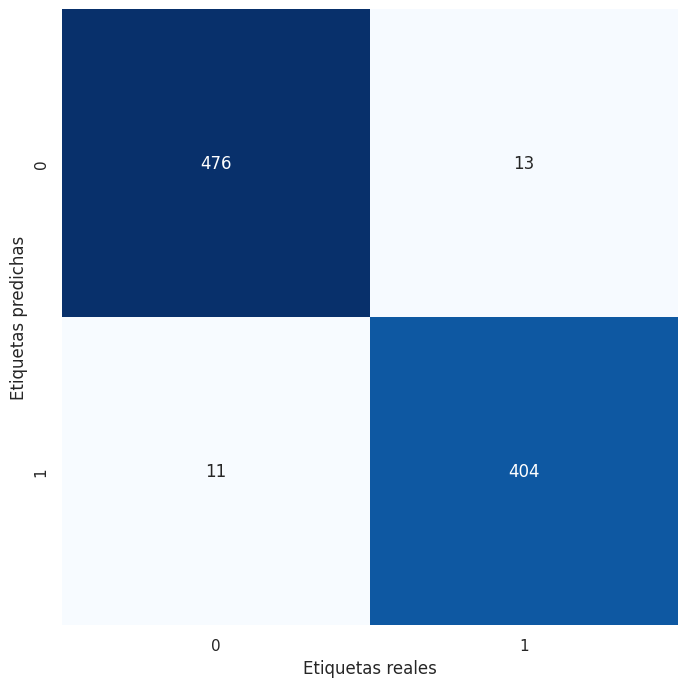

In [ ]:
plt.figure(figsize=(8,8))
mat = confusion_matrix(Y_test, y_pred_test)
sns.heatmap(mat.T, square=True, annot=True, cmap='Blues',fmt='d', cbar=False)
plt.xlabel('Etiquetas reales')
plt.ylabel('Etiquetas predichas')

## Conclusiones

Cuando se abordan tareas con una extensa variedad de características, se plantea el desafío de manejar redes neuronales de considerable tamaño. Tal aumento en la dimensionalidad conlleva distintos inconvenientes en términos computacionales, dadas las limitaciones de memoria y procesamiento. En algunas instancias, las propiedades del espacio de entrada pueden estar interrelacionadas, pero las redes neuronales no cuentan con la capacidad para determinar si alguna de ellas puede ser descartada sin afectar negativamente la calidad de la representación. En el contexto de procesamiento de imágenes, los modelos por sí solos no poseen la capacidad intrínseca de reconocer patrones que podrían ser omitidos durante el proceso de entrenamiento.

En el panorama descrito se desenvuelven esquemas como el _autoencoder_, una técnica que se aprovecha para reducir la dimensionalidad de las imágenes mediante el aprendizaje de una representación más compacta. No obstante, es importante tener en cuenta que la compresión excesiva puede derivar en la pérdida de información relevante. Por lo tanto, la determinación del número óptimo de neuronas en la capa oculta del autoencoder es una decisión crucial que debe tomarse cuidadosamente. En este caso específico, se ha encontrado que un número de 256 neuronas proporciona un tamaño adecuado para el espacio latente. En general, y en virtud de lo anterior, se puede esperar que las redes neuronales con _encoders_ ofrezcan una mayor precisión y robustez que las que no las utilizan, especialmente cuando los datos son complejos, escasos o ruidosos.

Por otro lado, como se exploró en la segunda actividad, los autoencoders se pueden entrenar previamente y luego transferir su conocimiento a otras redes neuronales. Tal propiedad facilita el aprendizaje de los clasificadores, puesto que pueden operar con menos parámetros y se mejora la capacidad de generalización. A continuación, se presenta una tabla que compara la arquitectura y desempeño de un perceptron multicapa con y sin un _encoder_:

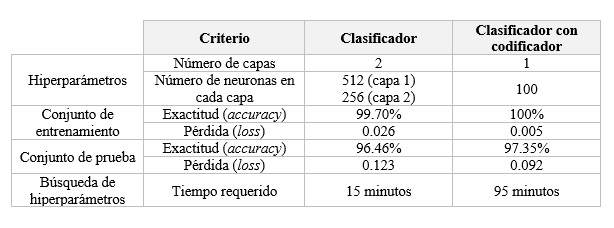

A raíz de lo anterior, si el criterio de decisión para la organización que requiera técnicas de Deep Learning como las abordadas en este taller es puramente en términos de métricas de desempeño, se recomienda optar por una red neuronal compuesta por un _encoder_ y un clasificador. Además, el codificador que se construya puede resultar de utilidad en otros proyectos que también trabajen con colecciones de imágenes. Sin embargo, se debe contemplar que dichas redes neuronales pueden ser más costosas computacionalmente, exigiendo más tiempo de entrenamiento y ajuste de un mayor número de parámetros.